# Sciplex Dose

In [1]:
ood_seed = 9

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Nutlin', '50.0'), 265)

Removed datapoint: 265


In [10]:
adata

AnnData object with n_obs × n_vars = 14546 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_ood-seed_expression-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1720,1541,1432,1717,1434,1581,1225,987
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1550,3588,1973,2806,1720
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 435,420,360,454,356,359,277,248
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 389,880,522,683,435
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:07<1:19:36,  7.97s/it]

Epoch 1/600:   0%|          | 1/600 [00:07<1:19:36,  7.97s/it, v_num=1, total_loss_train=2.69e+3, kl_local_train=37.1]

Epoch 2/600:   0%|          | 1/600 [00:08<1:19:36,  7.97s/it, v_num=1, total_loss_train=2.69e+3, kl_local_train=37.1]

Epoch 2/600:   0%|          | 2/600 [00:15<1:15:14,  7.55s/it, v_num=1, total_loss_train=2.69e+3, kl_local_train=37.1]

Epoch 2/600:   0%|          | 2/600 [00:15<1:15:14,  7.55s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=66.8]

Epoch 3/600:   0%|          | 2/600 [00:15<1:15:14,  7.55s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=66.8]

Epoch 3/600:   0%|          | 3/600 [00:22<1:13:30,  7.39s/it, v_num=1, total_loss_train=2.22e+3, kl_local_train=66.8]

Epoch 3/600:   0%|          | 3/600 [00:22<1:13:30,  7.39s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=71.7] 

Epoch 4/600:   0%|          | 3/600 [00:22<1:13:30,  7.39s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=71.7]

Epoch 4/600:   1%|          | 4/600 [00:29<1:12:35,  7.31s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=71.7]

Epoch 4/600:   1%|          | 4/600 [00:29<1:12:35,  7.31s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=70.7]

Epoch 5/600:   1%|          | 4/600 [00:29<1:12:35,  7.31s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=70.7]

Epoch 5/600:   1%|          | 5/600 [00:37<1:13:17,  7.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=70.7]

Epoch 5/600:   1%|          | 5/600 [00:37<1:13:17,  7.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=60]  

Epoch 6/600:   1%|          | 5/600 [00:37<1:13:17,  7.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=60]

Epoch 6/600:   1%|          | 6/600 [00:44<1:12:44,  7.35s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=60]

Epoch 6/600:   1%|          | 6/600 [00:44<1:12:44,  7.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 7/600:   1%|          | 6/600 [00:44<1:12:44,  7.35s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 7/600:   1%|          | 7/600 [00:51<1:10:37,  7.15s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 7/600:   1%|          | 7/600 [00:51<1:10:37,  7.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 8/600:   1%|          | 7/600 [00:51<1:10:37,  7.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 8/600:   1%|▏         | 8/600 [00:57<1:09:16,  7.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 8/600:   1%|▏         | 8/600 [00:57<1:09:16,  7.02s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 9/600:   1%|▏         | 8/600 [00:57<1:09:16,  7.02s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 9/600:   2%|▏         | 9/600 [01:04<1:08:22,  6.94s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 9/600:   2%|▏         | 9/600 [01:04<1:08:22,  6.94s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 10/600:   2%|▏         | 9/600 [01:04<1:08:22,  6.94s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 10/600:   2%|▏         | 10/600 [01:11<1:08:34,  6.97s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 10/600:   2%|▏         | 10/600 [01:11<1:08:34,  6.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=62, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]  

Epoch 11/600:   2%|▏         | 10/600 [01:12<1:08:34,  6.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=62, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 11/600:   2%|▏         | 11/600 [01:19<1:09:32,  7.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=62, metric_mi|dose_training_train=0.0428, metric_mi|condition_train=0.0587]

Epoch 11/600:   2%|▏         | 11/600 [01:19<1:09:32,  7.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17] 

Epoch 12/600:   2%|▏         | 11/600 [01:19<1:09:32,  7.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 12/600:   2%|▏         | 12/600 [01:25<1:08:27,  6.99s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 12/600:   2%|▏         | 12/600 [01:25<1:08:27,  6.99s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 13/600:   2%|▏         | 12/600 [01:25<1:08:27,  6.99s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 13/600:   2%|▏         | 13/600 [01:32<1:07:40,  6.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 13/600:   2%|▏         | 13/600 [01:32<1:07:40,  6.92s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 14/600:   2%|▏         | 13/600 [01:32<1:07:40,  6.92s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 14/600:   2%|▏         | 14/600 [01:39<1:07:05,  6.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 14/600:   2%|▏         | 14/600 [01:39<1:07:05,  6.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 15/600:   2%|▏         | 14/600 [01:39<1:07:05,  6.87s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 15/600:   2%|▎         | 15/600 [01:46<1:07:37,  6.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 15/600:   2%|▎         | 15/600 [01:46<1:07:37,  6.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 16/600:   2%|▎         | 15/600 [01:46<1:07:37,  6.94s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 16/600:   3%|▎         | 16/600 [01:54<1:09:41,  7.16s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.17]

Epoch 16/600:   3%|▎         | 16/600 [01:54<1:09:41,  7.16s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=112, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 17/600:   3%|▎         | 16/600 [01:54<1:09:41,  7.16s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=112, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 17/600:   3%|▎         | 17/600 [02:01<1:09:16,  7.13s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=112, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 17/600:   3%|▎         | 17/600 [02:01<1:09:16,  7.13s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 18/600:   3%|▎         | 17/600 [02:01<1:09:16,  7.13s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 18/600:   3%|▎         | 18/600 [02:08<1:08:54,  7.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 18/600:   3%|▎         | 18/600 [02:08<1:08:54,  7.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=145, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 19/600:   3%|▎         | 18/600 [02:08<1:08:54,  7.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=145, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 19/600:   3%|▎         | 19/600 [02:15<1:10:09,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=145, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 19/600:   3%|▎         | 19/600 [02:15<1:10:09,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=168, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 20/600:   3%|▎         | 19/600 [02:15<1:10:09,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=168, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 20/600:   3%|▎         | 20/600 [02:23<1:11:55,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=168, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 20/600:   3%|▎         | 20/600 [02:23<1:11:55,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=189, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 21/600:   3%|▎         | 20/600 [02:24<1:11:55,  7.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=189, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 21/600:   4%|▎         | 21/600 [02:31<1:13:43,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=189, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.157]

Epoch 21/600:   4%|▎         | 21/600 [02:31<1:13:43,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=203, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212] 

Epoch 22/600:   4%|▎         | 21/600 [02:31<1:13:43,  7.64s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=203, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 22/600:   4%|▎         | 22/600 [02:39<1:13:30,  7.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=203, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 22/600:   4%|▎         | 22/600 [02:39<1:13:30,  7.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=231, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 23/600:   4%|▎         | 22/600 [02:39<1:13:30,  7.63s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=231, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 23/600:   4%|▍         | 23/600 [02:46<1:13:17,  7.62s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=231, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 23/600:   4%|▍         | 23/600 [02:46<1:13:17,  7.62s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=242, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 24/600:   4%|▍         | 23/600 [02:46<1:13:17,  7.62s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=242, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 24/600:   4%|▍         | 24/600 [02:54<1:12:54,  7.59s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=242, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 24/600:   4%|▍         | 24/600 [02:54<1:12:54,  7.59s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=259, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 25/600:   4%|▍         | 24/600 [02:54<1:12:54,  7.59s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=259, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 25/600:   4%|▍         | 25/600 [03:02<1:14:10,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=259, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 25/600:   4%|▍         | 25/600 [03:02<1:14:10,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=270, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 26/600:   4%|▍         | 25/600 [03:03<1:14:10,  7.74s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=270, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 26/600:   4%|▍         | 26/600 [03:10<1:15:05,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=270, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.212]

Epoch 26/600:   4%|▍         | 26/600 [03:10<1:15:05,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=274, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 27/600:   4%|▍         | 26/600 [03:10<1:15:05,  7.85s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=274, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 27/600:   4%|▍         | 27/600 [03:18<1:14:18,  7.78s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=274, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 27/600:   4%|▍         | 27/600 [03:18<1:14:18,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=284, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 28/600:   4%|▍         | 27/600 [03:18<1:14:18,  7.78s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=284, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 28/600:   5%|▍         | 28/600 [03:25<1:13:44,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=284, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 28/600:   5%|▍         | 28/600 [03:25<1:13:44,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 29/600:   5%|▍         | 28/600 [03:25<1:13:44,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 29/600:   5%|▍         | 29/600 [03:33<1:13:12,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=290, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 29/600:   5%|▍         | 29/600 [03:33<1:13:12,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=285, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 30/600:   5%|▍         | 29/600 [03:33<1:13:12,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=285, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 30/600:   5%|▌         | 30/600 [03:41<1:14:09,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=285, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 30/600:   5%|▌         | 30/600 [03:41<1:14:09,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=279, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 31/600:   5%|▌         | 30/600 [03:42<1:14:09,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=279, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 31/600:   5%|▌         | 31/600 [03:49<1:14:58,  7.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=279, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.238]

Epoch 31/600:   5%|▌         | 31/600 [03:49<1:14:58,  7.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=283, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 32/600:   5%|▌         | 31/600 [03:49<1:14:58,  7.91s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=283, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 32/600:   5%|▌         | 32/600 [03:57<1:13:59,  7.82s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=283, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 32/600:   5%|▌         | 32/600 [03:57<1:13:59,  7.82s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=291, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 33/600:   5%|▌         | 32/600 [03:57<1:13:59,  7.82s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=291, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 33/600:   6%|▌         | 33/600 [04:04<1:13:11,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=291, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 33/600:   6%|▌         | 33/600 [04:04<1:13:11,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=289, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 34/600:   6%|▌         | 33/600 [04:04<1:13:11,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=289, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 34/600:   6%|▌         | 34/600 [04:12<1:12:41,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=289, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 34/600:   6%|▌         | 34/600 [04:12<1:12:41,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=288, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 35/600:   6%|▌         | 34/600 [04:12<1:12:41,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=288, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 35/600:   6%|▌         | 35/600 [04:20<1:12:59,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=288, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 35/600:   6%|▌         | 35/600 [04:20<1:12:59,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=305, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 36/600:   6%|▌         | 35/600 [04:20<1:12:59,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=305, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 36/600:   6%|▌         | 36/600 [04:28<1:13:55,  7.87s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=305, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.255]

Epoch 36/600:   6%|▌         | 36/600 [04:28<1:13:55,  7.87s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=305, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26] 

Epoch 37/600:   6%|▌         | 36/600 [04:28<1:13:55,  7.87s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=305, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 37/600:   6%|▌         | 37/600 [04:36<1:13:10,  7.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=305, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 37/600:   6%|▌         | 37/600 [04:36<1:13:10,  7.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=304, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 38/600:   6%|▌         | 37/600 [04:36<1:13:10,  7.80s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=304, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 38/600:   6%|▋         | 38/600 [04:43<1:12:36,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=304, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 38/600:   6%|▋         | 38/600 [04:43<1:12:36,  7.75s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=289, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 39/600:   6%|▋         | 38/600 [04:43<1:12:36,  7.75s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=289, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 39/600:   6%|▋         | 39/600 [04:51<1:12:06,  7.71s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=289, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 39/600:   6%|▋         | 39/600 [04:51<1:12:06,  7.71s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=286, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 40/600:   6%|▋         | 39/600 [04:51<1:12:06,  7.71s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=286, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 40/600:   7%|▋         | 40/600 [04:59<1:12:24,  7.76s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=286, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 40/600:   7%|▋         | 40/600 [04:59<1:12:24,  7.76s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=295, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 41/600:   7%|▋         | 40/600 [04:59<1:12:24,  7.76s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=295, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 41/600:   7%|▋         | 41/600 [05:07<1:13:16,  7.86s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=295, metric_mi|dose_training_train=0.237, metric_mi|condition_train=0.26]

Epoch 41/600:   7%|▋         | 41/600 [05:07<1:13:16,  7.86s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=293, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 42/600:   7%|▋         | 41/600 [05:07<1:13:16,  7.86s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=293, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 42/600:   7%|▋         | 42/600 [05:15<1:12:28,  7.79s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=293, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 42/600:   7%|▋         | 42/600 [05:15<1:12:28,  7.79s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=290, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 43/600:   7%|▋         | 42/600 [05:15<1:12:28,  7.79s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=290, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 43/600:   7%|▋         | 43/600 [05:22<1:11:47,  7.73s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=290, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 43/600:   7%|▋         | 43/600 [05:22<1:11:47,  7.73s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=282, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262] 

Epoch 44/600:   7%|▋         | 43/600 [05:22<1:11:47,  7.73s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=282, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 44/600:   7%|▋         | 44/600 [05:30<1:11:21,  7.70s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=282, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 44/600:   7%|▋         | 44/600 [05:30<1:11:21,  7.70s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=281, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 45/600:   7%|▋         | 44/600 [05:30<1:11:21,  7.70s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=281, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 45/600:   8%|▊         | 45/600 [05:38<1:11:40,  7.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=281, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 45/600:   8%|▊         | 45/600 [05:38<1:11:40,  7.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=285, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 46/600:   8%|▊         | 45/600 [05:38<1:11:40,  7.75s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=285, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 46/600:   8%|▊         | 46/600 [05:46<1:12:38,  7.87s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=285, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.262]

Epoch 46/600:   8%|▊         | 46/600 [05:46<1:12:38,  7.87s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=285, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 47/600:   8%|▊         | 46/600 [05:46<1:12:38,  7.87s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=285, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 47/600:   8%|▊         | 47/600 [05:53<1:11:56,  7.81s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=285, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 47/600:   8%|▊         | 47/600 [05:53<1:11:56,  7.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=290, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 48/600:   8%|▊         | 47/600 [05:53<1:11:56,  7.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=290, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 48/600:   8%|▊         | 48/600 [06:01<1:11:16,  7.75s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=290, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 48/600:   8%|▊         | 48/600 [06:01<1:11:16,  7.75s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 49/600:   8%|▊         | 48/600 [06:01<1:11:16,  7.75s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 49/600:   8%|▊         | 49/600 [06:09<1:10:50,  7.71s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 49/600:   8%|▊         | 49/600 [06:09<1:10:50,  7.71s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=279, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 50/600:   8%|▊         | 49/600 [06:09<1:10:50,  7.71s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=279, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 50/600:   8%|▊         | 50/600 [06:17<1:11:13,  7.77s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=279, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 50/600:   8%|▊         | 50/600 [06:17<1:11:13,  7.77s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 51/600:   8%|▊         | 50/600 [06:17<1:11:13,  7.77s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 51/600:   8%|▊         | 51/600 [06:25<1:12:08,  7.88s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.255, metric_mi|condition_train=0.258]

Epoch 51/600:   8%|▊         | 51/600 [06:25<1:12:08,  7.88s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261] 

Epoch 52/600:   8%|▊         | 51/600 [06:25<1:12:08,  7.88s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 52/600:   9%|▊         | 52/600 [06:32<1:11:19,  7.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 52/600:   9%|▊         | 52/600 [06:32<1:11:19,  7.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=261, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 53/600:   9%|▊         | 52/600 [06:32<1:11:19,  7.81s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=261, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 53/600:   9%|▉         | 53/600 [06:40<1:10:37,  7.75s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=261, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 53/600:   9%|▉         | 53/600 [06:40<1:10:37,  7.75s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 54/600:   9%|▉         | 53/600 [06:40<1:10:37,  7.75s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 54/600:   9%|▉         | 54/600 [06:48<1:10:13,  7.72s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=267, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 54/600:   9%|▉         | 54/600 [06:48<1:10:13,  7.72s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 55/600:   9%|▉         | 54/600 [06:48<1:10:13,  7.72s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 55/600:   9%|▉         | 55/600 [06:56<1:10:44,  7.79s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=272, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 55/600:   9%|▉         | 55/600 [06:56<1:10:44,  7.79s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=259, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 56/600:   9%|▉         | 55/600 [06:56<1:10:44,  7.79s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=259, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 56/600:   9%|▉         | 56/600 [07:04<1:12:27,  7.99s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=259, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.261]

Epoch 56/600:   9%|▉         | 56/600 [07:04<1:12:27,  7.99s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=247, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 57/600:   9%|▉         | 56/600 [07:04<1:12:27,  7.99s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=247, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 57/600:  10%|▉         | 57/600 [07:12<1:12:02,  7.96s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=247, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 57/600:  10%|▉         | 57/600 [07:12<1:12:02,  7.96s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=249, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 58/600:  10%|▉         | 57/600 [07:12<1:12:02,  7.96s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=249, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 58/600:  10%|▉         | 58/600 [07:20<1:11:45,  7.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=249, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 58/600:  10%|▉         | 58/600 [07:20<1:11:45,  7.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=250, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 59/600:  10%|▉         | 58/600 [07:20<1:11:45,  7.94s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=250, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 59/600:  10%|▉         | 59/600 [07:28<1:12:01,  7.99s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=250, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 59/600:  10%|▉         | 59/600 [07:28<1:12:01,  7.99s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=244, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265] 

Epoch 60/600:  10%|▉         | 59/600 [07:28<1:12:01,  7.99s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=244, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 60/600:  10%|█         | 60/600 [07:36<1:12:15,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=244, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 60/600:  10%|█         | 60/600 [07:36<1:12:15,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=242, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 61/600:  10%|█         | 60/600 [07:37<1:12:15,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=242, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 61/600:  10%|█         | 61/600 [07:44<1:13:06,  8.14s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=242, metric_mi|dose_training_train=0.262, metric_mi|condition_train=0.265]

Epoch 61/600:  10%|█         | 61/600 [07:44<1:13:06,  8.14s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=245, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 62/600:  10%|█         | 61/600 [07:44<1:13:06,  8.14s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=245, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 62/600:  10%|█         | 62/600 [07:52<1:12:17,  8.06s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=245, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 62/600:  10%|█         | 62/600 [07:52<1:12:17,  8.06s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 63/600:  10%|█         | 62/600 [07:52<1:12:17,  8.06s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 63/600:  10%|█         | 63/600 [08:00<1:11:42,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 63/600:  10%|█         | 63/600 [08:00<1:11:42,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 64/600:  10%|█         | 63/600 [08:00<1:11:42,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 64/600:  11%|█         | 64/600 [08:08<1:11:18,  7.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=237, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 64/600:  11%|█         | 64/600 [08:08<1:11:18,  7.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 65/600:  11%|█         | 64/600 [08:08<1:11:18,  7.98s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 65/600:  11%|█         | 65/600 [08:16<1:11:37,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=233, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 65/600:  11%|█         | 65/600 [08:16<1:11:37,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 66/600:  11%|█         | 65/600 [08:17<1:11:37,  8.03s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 66/600:  11%|█         | 66/600 [08:25<1:12:23,  8.13s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=235, metric_mi|dose_training_train=0.263, metric_mi|condition_train=0.266]

Epoch 66/600:  11%|█         | 66/600 [08:25<1:12:23,  8.13s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263] 

Epoch 67/600:  11%|█         | 66/600 [08:25<1:12:23,  8.13s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 67/600:  11%|█         | 67/600 [08:32<1:11:27,  8.04s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=234, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 67/600:  11%|█         | 67/600 [08:32<1:11:27,  8.04s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=231, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 68/600:  11%|█         | 67/600 [08:32<1:11:27,  8.04s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=231, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 68/600:  11%|█▏        | 68/600 [08:40<1:10:54,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=231, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 68/600:  11%|█▏        | 68/600 [08:40<1:10:54,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=230, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 69/600:  11%|█▏        | 68/600 [08:40<1:10:54,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=230, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 69/600:  12%|█▏        | 69/600 [08:48<1:10:25,  7.96s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=230, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 69/600:  12%|█▏        | 69/600 [08:48<1:10:25,  7.96s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=232, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 70/600:  12%|█▏        | 69/600 [08:48<1:10:25,  7.96s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=232, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 70/600:  12%|█▏        | 70/600 [08:56<1:10:44,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=232, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 70/600:  12%|█▏        | 70/600 [08:56<1:10:44,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=226, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 71/600:  12%|█▏        | 70/600 [08:57<1:10:44,  8.01s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=226, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 71/600:  12%|█▏        | 71/600 [09:05<1:11:34,  8.12s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=226, metric_mi|dose_training_train=0.26, metric_mi|condition_train=0.263]

Epoch 71/600:  12%|█▏        | 71/600 [09:05<1:11:34,  8.12s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=217, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 72/600:  12%|█▏        | 71/600 [09:05<1:11:34,  8.12s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=217, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 72/600:  12%|█▏        | 72/600 [09:13<1:10:47,  8.05s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=217, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 72/600:  12%|█▏        | 72/600 [09:13<1:10:47,  8.05s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 73/600:  12%|█▏        | 72/600 [09:13<1:10:47,  8.05s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 73/600:  12%|█▏        | 73/600 [09:20<1:10:13,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=220, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 73/600:  12%|█▏        | 73/600 [09:20<1:10:13,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=218, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 74/600:  12%|█▏        | 73/600 [09:21<1:10:13,  8.00s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=218, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 74/600:  12%|█▏        | 74/600 [09:28<1:09:49,  7.96s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=218, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 74/600:  12%|█▏        | 74/600 [09:28<1:09:49,  7.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=220, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 75/600:  12%|█▏        | 74/600 [09:28<1:09:49,  7.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=220, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 75/600:  12%|█▎        | 75/600 [09:37<1:10:07,  8.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=220, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 75/600:  12%|█▎        | 75/600 [09:37<1:10:07,  8.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=212, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 76/600:  12%|█▎        | 75/600 [09:37<1:10:07,  8.02s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=212, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 76/600:  13%|█▎        | 76/600 [09:45<1:10:53,  8.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=212, metric_mi|dose_training_train=0.253, metric_mi|condition_train=0.256]

Epoch 76/600:  13%|█▎        | 76/600 [09:45<1:10:53,  8.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=214, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 77/600:  13%|█▎        | 76/600 [09:45<1:10:53,  8.12s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=214, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 77/600:  13%|█▎        | 77/600 [09:53<1:10:06,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=214, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 77/600:  13%|█▎        | 77/600 [09:53<1:10:06,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=211, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 78/600:  13%|█▎        | 77/600 [09:53<1:10:06,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=211, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 78/600:  13%|█▎        | 78/600 [10:01<1:09:34,  8.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=211, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 78/600:  13%|█▎        | 78/600 [10:01<1:09:34,  8.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 79/600:  13%|█▎        | 78/600 [10:01<1:09:34,  8.00s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 79/600:  13%|█▎        | 79/600 [10:09<1:09:07,  7.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=210, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 79/600:  13%|█▎        | 79/600 [10:09<1:09:07,  7.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 80/600:  13%|█▎        | 79/600 [10:09<1:09:07,  7.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 80/600:  13%|█▎        | 80/600 [10:17<1:09:23,  8.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=201, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 80/600:  13%|█▎        | 80/600 [10:17<1:09:23,  8.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=198, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 81/600:  13%|█▎        | 80/600 [10:17<1:09:23,  8.01s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=198, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 81/600:  14%|█▎        | 81/600 [10:25<1:09:30,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=198, metric_mi|dose_training_train=0.245, metric_mi|condition_train=0.249]

Epoch 81/600:  14%|█▎        | 81/600 [10:25<1:09:30,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=200, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 82/600:  14%|█▎        | 81/600 [10:25<1:09:30,  8.04s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=200, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 82/600:  14%|█▎        | 82/600 [10:32<1:08:21,  7.92s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=200, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 82/600:  14%|█▎        | 82/600 [10:32<1:08:21,  7.92s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=194, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 83/600:  14%|█▎        | 82/600 [10:32<1:08:21,  7.92s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=194, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 83/600:  14%|█▍        | 83/600 [10:40<1:07:33,  7.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=194, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 83/600:  14%|█▍        | 83/600 [10:40<1:07:33,  7.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=195, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 84/600:  14%|█▍        | 83/600 [10:40<1:07:33,  7.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=195, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 84/600:  14%|█▍        | 84/600 [10:48<1:06:57,  7.78s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=195, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 84/600:  14%|█▍        | 84/600 [10:48<1:06:57,  7.78s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 85/600:  14%|█▍        | 84/600 [10:48<1:06:57,  7.78s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 85/600:  14%|█▍        | 85/600 [10:56<1:07:05,  7.82s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 85/600:  14%|█▍        | 85/600 [10:56<1:07:05,  7.82s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=189, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 86/600:  14%|█▍        | 85/600 [10:56<1:07:05,  7.82s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=189, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 86/600:  14%|█▍        | 86/600 [11:04<1:07:44,  7.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=189, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.246]

Epoch 86/600:  14%|█▍        | 86/600 [11:04<1:07:44,  7.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25] 

Epoch 87/600:  14%|█▍        | 86/600 [11:04<1:07:44,  7.91s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 87/600:  14%|█▍        | 87/600 [11:11<1:07:00,  7.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=190, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 87/600:  14%|█▍        | 87/600 [11:11<1:07:00,  7.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=187, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 88/600:  14%|█▍        | 87/600 [11:11<1:07:00,  7.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=187, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 88/600:  15%|█▍        | 88/600 [11:19<1:06:25,  7.78s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=187, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 88/600:  15%|█▍        | 88/600 [11:19<1:06:25,  7.78s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=186, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 89/600:  15%|█▍        | 88/600 [11:19<1:06:25,  7.78s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=186, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 89/600:  15%|█▍        | 89/600 [11:27<1:05:59,  7.75s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=186, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 89/600:  15%|█▍        | 89/600 [11:27<1:05:59,  7.75s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 90/600:  15%|█▍        | 89/600 [11:27<1:05:59,  7.75s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 90/600:  15%|█▌        | 90/600 [11:35<1:07:03,  7.89s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=181, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 90/600:  15%|█▌        | 90/600 [11:35<1:07:03,  7.89s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=182, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 91/600:  15%|█▌        | 90/600 [11:35<1:07:03,  7.89s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=182, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 91/600:  15%|█▌        | 91/600 [11:43<1:07:33,  7.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=182, metric_mi|dose_training_train=0.238, metric_mi|condition_train=0.25]

Epoch 91/600:  15%|█▌        | 91/600 [11:43<1:07:33,  7.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=177, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 92/600:  15%|█▌        | 91/600 [11:43<1:07:33,  7.96s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=177, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 92/600:  15%|█▌        | 92/600 [11:51<1:06:41,  7.88s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=177, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 92/600:  15%|█▌        | 92/600 [11:51<1:06:41,  7.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 93/600:  15%|█▌        | 92/600 [11:51<1:06:41,  7.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 93/600:  16%|█▌        | 93/600 [11:58<1:06:03,  7.82s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 93/600:  16%|█▌        | 93/600 [11:58<1:06:03,  7.82s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 94/600:  16%|█▌        | 93/600 [11:58<1:06:03,  7.82s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 94/600:  16%|█▌        | 94/600 [12:06<1:05:40,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 94/600:  16%|█▌        | 94/600 [12:06<1:05:40,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 95/600:  16%|█▌        | 94/600 [12:06<1:05:40,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 95/600:  16%|█▌        | 95/600 [12:14<1:06:33,  7.91s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 95/600:  16%|█▌        | 95/600 [12:14<1:06:33,  7.91s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 96/600:  16%|█▌        | 95/600 [12:15<1:06:33,  7.91s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 96/600:  16%|█▌        | 96/600 [12:22<1:07:06,  7.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=175, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.246]

Epoch 96/600:  16%|█▌        | 96/600 [12:22<1:07:06,  7.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 97/600:  16%|█▌        | 96/600 [12:23<1:07:06,  7.99s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 97/600:  16%|█▌        | 97/600 [12:30<1:06:24,  7.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=174, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 97/600:  16%|█▌        | 97/600 [12:30<1:06:24,  7.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 98/600:  16%|█▌        | 97/600 [12:30<1:06:24,  7.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 98/600:  16%|█▋        | 98/600 [12:38<1:05:32,  7.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=172, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 98/600:  16%|█▋        | 98/600 [12:38<1:05:32,  7.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 99/600:  16%|█▋        | 98/600 [12:38<1:05:32,  7.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 99/600:  16%|█▋        | 99/600 [12:46<1:04:55,  7.78s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=173, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 99/600:  16%|█▋        | 99/600 [12:46<1:04:55,  7.78s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 100/600:  16%|█▋        | 99/600 [12:46<1:04:55,  7.78s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 100/600:  17%|█▋        | 100/600 [12:53<1:04:55,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=171, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 100/600:  17%|█▋        | 100/600 [12:53<1:04:55,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 101/600:  17%|█▋        | 100/600 [12:54<1:04:55,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 101/600:  17%|█▋        | 101/600 [13:01<1:05:33,  7.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.241]

Epoch 101/600:  17%|█▋        | 101/600 [13:01<1:05:33,  7.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24] 

Epoch 102/600:  17%|█▋        | 101/600 [13:01<1:05:33,  7.88s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 102/600:  17%|█▋        | 102/600 [13:09<1:04:47,  7.81s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=170, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 102/600:  17%|█▋        | 102/600 [13:09<1:04:47,  7.81s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 103/600:  17%|█▋        | 102/600 [13:09<1:04:47,  7.81s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 103/600:  17%|█▋        | 103/600 [13:17<1:04:11,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=169, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 103/600:  17%|█▋        | 103/600 [13:17<1:04:11,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 104/600:  17%|█▋        | 103/600 [13:17<1:04:11,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 104/600:  17%|█▋        | 104/600 [13:24<1:03:44,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=168, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 104/600:  17%|█▋        | 104/600 [13:24<1:03:44,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 105/600:  17%|█▋        | 104/600 [13:24<1:03:44,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 105/600:  18%|█▊        | 105/600 [13:32<1:03:53,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=167, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 105/600:  18%|█▊        | 105/600 [13:32<1:03:53,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 106/600:  18%|█▊        | 105/600 [13:33<1:03:53,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 106/600:  18%|█▊        | 106/600 [13:40<1:04:44,  7.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.24]

Epoch 106/600:  18%|█▊        | 106/600 [13:40<1:04:44,  7.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 107/600:  18%|█▊        | 106/600 [13:40<1:04:44,  7.86s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 107/600:  18%|█▊        | 107/600 [13:48<1:04:00,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=166, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 107/600:  18%|█▊        | 107/600 [13:48<1:04:00,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 108/600:  18%|█▊        | 107/600 [13:48<1:04:00,  7.79s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 108/600:  18%|█▊        | 108/600 [13:56<1:03:28,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 108/600:  18%|█▊        | 108/600 [13:56<1:03:28,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 109/600:  18%|█▊        | 108/600 [13:56<1:03:28,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 109/600:  18%|█▊        | 109/600 [14:03<1:03:02,  7.70s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 109/600:  18%|█▊        | 109/600 [14:03<1:03:02,  7.70s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 110/600:  18%|█▊        | 109/600 [14:03<1:03:02,  7.70s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 110/600:  18%|█▊        | 110/600 [14:11<1:03:12,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=164, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 110/600:  18%|█▊        | 110/600 [14:11<1:03:12,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 111/600:  18%|█▊        | 110/600 [14:11<1:03:12,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 111/600:  18%|█▊        | 111/600 [14:19<1:03:57,  7.85s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=165, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.235]

Epoch 111/600:  18%|█▊        | 111/600 [14:19<1:03:57,  7.85s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 112/600:  18%|█▊        | 111/600 [14:19<1:03:57,  7.85s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 112/600:  19%|█▊        | 112/600 [14:27<1:03:16,  7.78s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=161, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 112/600:  19%|█▊        | 112/600 [14:27<1:03:16,  7.78s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 113/600:  19%|█▊        | 112/600 [14:27<1:03:16,  7.78s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 113/600:  19%|█▉        | 113/600 [14:34<1:02:43,  7.73s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 113/600:  19%|█▉        | 113/600 [14:34<1:02:43,  7.73s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 114/600:  19%|█▉        | 113/600 [14:34<1:02:43,  7.73s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 114/600:  19%|█▉        | 114/600 [14:42<1:02:19,  7.69s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 114/600:  19%|█▉        | 114/600 [14:42<1:02:19,  7.69s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 115/600:  19%|█▉        | 114/600 [14:42<1:02:19,  7.69s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 115/600:  19%|█▉        | 115/600 [14:50<1:03:17,  7.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 115/600:  19%|█▉        | 115/600 [14:50<1:03:17,  7.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 116/600:  19%|█▉        | 115/600 [14:51<1:03:17,  7.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 116/600:  19%|█▉        | 116/600 [14:58<1:03:51,  7.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=160, metric_mi|dose_training_train=0.228, metric_mi|condition_train=0.239]

Epoch 116/600:  19%|█▉        | 116/600 [14:58<1:03:51,  7.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 117/600:  19%|█▉        | 116/600 [14:58<1:03:51,  7.92s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 117/600:  20%|█▉        | 117/600 [15:06<1:02:57,  7.82s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 117/600:  20%|█▉        | 117/600 [15:06<1:02:57,  7.82s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 118/600:  20%|█▉        | 117/600 [15:06<1:02:57,  7.82s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 118/600:  20%|█▉        | 118/600 [15:13<1:02:17,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=156, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 118/600:  20%|█▉        | 118/600 [15:13<1:02:17,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 119/600:  20%|█▉        | 118/600 [15:13<1:02:17,  7.75s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 119/600:  20%|█▉        | 119/600 [15:21<1:01:50,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=158, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 119/600:  20%|█▉        | 119/600 [15:21<1:01:50,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 120/600:  20%|█▉        | 119/600 [15:21<1:01:50,  7.71s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 120/600:  20%|██        | 120/600 [15:29<1:01:52,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=155, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 120/600:  20%|██        | 120/600 [15:29<1:01:52,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 121/600:  20%|██        | 120/600 [15:29<1:01:52,  7.74s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 121/600:  20%|██        | 121/600 [15:37<1:02:32,  7.83s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=153, metric_mi|dose_training_train=0.223, metric_mi|condition_train=0.228]

Epoch 121/600:  20%|██        | 121/600 [15:37<1:02:32,  7.83s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 122/600:  20%|██        | 121/600 [15:37<1:02:32,  7.83s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 122/600:  20%|██        | 122/600 [15:44<1:01:46,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 122/600:  20%|██        | 122/600 [15:44<1:01:46,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 123/600:  20%|██        | 122/600 [15:44<1:01:46,  7.75s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 123/600:  20%|██        | 123/600 [15:52<1:01:12,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 123/600:  20%|██        | 123/600 [15:52<1:01:12,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 124/600:  20%|██        | 123/600 [15:52<1:01:12,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 124/600:  21%|██        | 124/600 [16:00<1:00:47,  7.66s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=152, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 124/600:  21%|██        | 124/600 [16:00<1:00:47,  7.66s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 125/600:  21%|██        | 124/600 [16:00<1:00:47,  7.66s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 125/600:  21%|██        | 125/600 [16:07<1:00:56,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 125/600:  21%|██        | 125/600 [16:07<1:00:56,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 126/600:  21%|██        | 125/600 [16:08<1:00:56,  7.70s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 126/600:  21%|██        | 126/600 [16:15<1:01:40,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.226]

Epoch 126/600:  21%|██        | 126/600 [16:15<1:01:40,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 127/600:  21%|██        | 126/600 [16:15<1:01:40,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 127/600:  21%|██        | 127/600 [16:23<1:00:57,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 127/600:  21%|██        | 127/600 [16:23<1:00:57,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██        | 127/600 [16:23<1:00:57,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██▏       | 128/600 [16:31<1:00:26,  7.68s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 128/600:  21%|██▏       | 128/600 [16:31<1:00:26,  7.68s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 129/600:  21%|██▏       | 128/600 [16:31<1:00:26,  7.68s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 129/600:  22%|██▏       | 129/600 [16:38<1:00:03,  7.65s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=149, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 129/600:  22%|██▏       | 129/600 [16:38<1:00:03,  7.65s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 129/600 [16:38<1:00:03,  7.65s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 130/600 [16:46<1:01:03,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 130/600:  22%|██▏       | 130/600 [16:46<1:01:03,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 130/600 [16:47<1:01:03,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 131/600 [16:54<1:01:36,  7.88s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=147, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.235]

Epoch 131/600:  22%|██▏       | 131/600 [16:54<1:01:36,  7.88s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 132/600:  22%|██▏       | 131/600 [16:54<1:01:36,  7.88s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 132/600:  22%|██▏       | 132/600 [17:02<1:00:46,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 132/600:  22%|██▏       | 132/600 [17:02<1:00:46,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 133/600:  22%|██▏       | 132/600 [17:02<1:00:46,  7.79s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 133/600:  22%|██▏       | 133/600 [17:09<1:00:12,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 133/600:  22%|██▏       | 133/600 [17:09<1:00:12,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 134/600:  22%|██▏       | 133/600 [17:10<1:00:12,  7.73s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 134/600:  22%|██▏       | 134/600 [17:17<59:45,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=146, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]  

Epoch 134/600:  22%|██▏       | 134/600 [17:17<59:45,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 135/600:  22%|██▏       | 134/600 [17:17<59:45,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 135/600:  22%|██▎       | 135/600 [17:25<1:00:47,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 135/600:  22%|██▎       | 135/600 [17:25<1:00:47,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 136/600:  22%|██▎       | 135/600 [17:26<1:00:47,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 136/600:  23%|██▎       | 136/600 [17:33<1:01:26,  7.95s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.229]

Epoch 136/600:  23%|██▎       | 136/600 [17:33<1:01:26,  7.95s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 137/600:  23%|██▎       | 136/600 [17:33<1:01:26,  7.95s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 137/600:  23%|██▎       | 137/600 [17:41<1:00:29,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 137/600:  23%|██▎       | 137/600 [17:41<1:00:29,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 138/600:  23%|██▎       | 137/600 [17:41<1:00:29,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 138/600:  23%|██▎       | 138/600 [17:49<59:48,  7.77s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=144, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]  

Epoch 138/600:  23%|██▎       | 138/600 [17:49<59:48,  7.77s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 139/600:  23%|██▎       | 138/600 [17:49<59:48,  7.77s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 139/600:  23%|██▎       | 139/600 [17:56<59:18,  7.72s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 139/600:  23%|██▎       | 139/600 [17:56<59:18,  7.72s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 140/600:  23%|██▎       | 139/600 [17:56<59:18,  7.72s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 140/600:  23%|██▎       | 140/600 [18:04<59:22,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=143, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 140/600:  23%|██▎       | 140/600 [18:04<59:22,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 141/600:  23%|██▎       | 140/600 [18:05<59:22,  7.74s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 141/600:  24%|██▎       | 141/600 [18:12<1:00:01,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.224]

Epoch 141/600:  24%|██▎       | 141/600 [18:12<1:00:01,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231] 

Epoch 142/600:  24%|██▎       | 141/600 [18:12<1:00:01,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 142/600:  24%|██▎       | 142/600 [18:20<59:16,  7.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]  

Epoch 142/600:  24%|██▎       | 142/600 [18:20<59:16,  7.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 143/600:  24%|██▎       | 142/600 [18:20<59:16,  7.76s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 143/600:  24%|██▍       | 143/600 [18:27<58:42,  7.71s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 143/600:  24%|██▍       | 143/600 [18:27<58:42,  7.71s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 144/600:  24%|██▍       | 143/600 [18:27<58:42,  7.71s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 144/600:  24%|██▍       | 144/600 [18:35<58:24,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 144/600:  24%|██▍       | 144/600 [18:35<58:24,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 145/600:  24%|██▍       | 144/600 [18:35<58:24,  7.69s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 145/600:  24%|██▍       | 145/600 [18:43<59:38,  7.86s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 145/600:  24%|██▍       | 145/600 [18:43<59:38,  7.86s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 146/600:  24%|██▍       | 145/600 [18:44<59:38,  7.86s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 146/600:  24%|██▍       | 146/600 [18:51<1:00:20,  7.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.231]

Epoch 146/600:  24%|██▍       | 146/600 [18:51<1:00:20,  7.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 147/600:  24%|██▍       | 146/600 [18:51<1:00:20,  7.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 147/600:  24%|██▍       | 147/600 [18:59<59:33,  7.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]  

Epoch 147/600:  24%|██▍       | 147/600 [18:59<59:33,  7.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 148/600:  24%|██▍       | 147/600 [18:59<59:33,  7.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 148/600:  25%|██▍       | 148/600 [19:07<59:05,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 148/600:  25%|██▍       | 148/600 [19:07<59:05,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 149/600:  25%|██▍       | 148/600 [19:07<59:05,  7.85s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 149/600:  25%|██▍       | 149/600 [19:15<58:40,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=140, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 149/600:  25%|██▍       | 149/600 [19:15<58:40,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 150/600:  25%|██▍       | 149/600 [19:15<58:40,  7.81s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 150/600:  25%|██▌       | 150/600 [19:23<58:47,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 150/600:  25%|██▌       | 150/600 [19:23<58:47,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 151/600:  25%|██▌       | 150/600 [19:23<58:47,  7.84s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 151/600:  25%|██▌       | 151/600 [19:31<59:40,  7.97s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.228]

Epoch 151/600:  25%|██▌       | 151/600 [19:31<59:40,  7.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 152/600:  25%|██▌       | 151/600 [19:31<59:40,  7.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 152/600:  25%|██▌       | 152/600 [19:39<59:07,  7.92s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 152/600:  25%|██▌       | 152/600 [19:39<59:07,  7.92s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 153/600:  25%|██▌       | 152/600 [19:39<59:07,  7.92s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 153/600:  26%|██▌       | 153/600 [19:46<58:45,  7.89s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 153/600:  26%|██▌       | 153/600 [19:46<58:45,  7.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 154/600:  26%|██▌       | 153/600 [19:46<58:45,  7.89s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 154/600:  26%|██▌       | 154/600 [19:54<58:29,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 154/600:  26%|██▌       | 154/600 [19:54<58:29,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 155/600:  26%|██▌       | 154/600 [19:54<58:29,  7.87s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 155/600:  26%|██▌       | 155/600 [20:03<59:30,  8.02s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 155/600:  26%|██▌       | 155/600 [20:03<59:30,  8.02s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 156/600:  26%|██▌       | 155/600 [20:03<59:30,  8.02s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 156/600:  26%|██▌       | 156/600 [20:11<1:00:05,  8.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.221, metric_mi|condition_train=0.234]

Epoch 156/600:  26%|██▌       | 156/600 [20:11<1:00:05,  8.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23] 

Epoch 157/600:  26%|██▌       | 156/600 [20:11<1:00:05,  8.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 157/600:  26%|██▌       | 157/600 [20:19<59:15,  8.03s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=137, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]  

Epoch 157/600:  26%|██▌       | 157/600 [20:19<59:15,  8.03s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 158/600:  26%|██▌       | 157/600 [20:19<59:15,  8.03s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 158/600:  26%|██▋       | 158/600 [20:27<58:29,  7.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 158/600:  26%|██▋       | 158/600 [20:27<58:29,  7.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 159/600:  26%|██▋       | 158/600 [20:27<58:29,  7.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 159/600:  26%|██▋       | 159/600 [20:34<58:05,  7.90s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=136, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 159/600:  26%|██▋       | 159/600 [20:34<58:05,  7.90s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 160/600:  26%|██▋       | 159/600 [20:34<58:05,  7.90s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 160/600:  27%|██▋       | 160/600 [20:43<59:33,  8.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 160/600:  27%|██▋       | 160/600 [20:43<59:33,  8.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 161/600:  27%|██▋       | 160/600 [20:44<59:33,  8.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 161/600:  27%|██▋       | 161/600 [20:52<1:01:45,  8.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.23]

Epoch 161/600:  27%|██▋       | 161/600 [20:52<1:01:45,  8.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 162/600:  27%|██▋       | 161/600 [20:52<1:01:45,  8.44s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 162/600:  27%|██▋       | 162/600 [21:01<1:02:35,  8.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=135, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 162/600:  27%|██▋       | 162/600 [21:01<1:02:35,  8.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 163/600:  27%|██▋       | 162/600 [21:01<1:02:35,  8.57s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 163/600:  27%|██▋       | 163/600 [21:10<1:02:45,  8.62s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=134, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 163/600:  27%|██▋       | 163/600 [21:10<1:02:45,  8.62s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 164/600:  27%|██▋       | 163/600 [21:10<1:02:45,  8.62s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 164/600:  27%|██▋       | 164/600 [21:19<1:03:07,  8.69s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 164/600:  27%|██▋       | 164/600 [21:19<1:03:07,  8.69s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 165/600:  27%|██▋       | 164/600 [21:19<1:03:07,  8.69s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 165/600:  28%|██▊       | 165/600 [21:28<1:04:56,  8.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 165/600:  28%|██▊       | 165/600 [21:28<1:04:56,  8.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 166/600:  28%|██▊       | 165/600 [21:29<1:04:56,  8.96s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 166/600:  28%|██▊       | 166/600 [21:37<1:05:28,  9.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.233]

Epoch 166/600:  28%|██▊       | 166/600 [21:37<1:05:28,  9.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 167/600:  28%|██▊       | 166/600 [21:37<1:05:28,  9.05s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 167/600:  28%|██▊       | 167/600 [21:46<1:04:51,  8.99s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 167/600:  28%|██▊       | 167/600 [21:46<1:04:51,  8.99s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 168/600:  28%|██▊       | 167/600 [21:46<1:04:51,  8.99s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 168/600:  28%|██▊       | 168/600 [21:55<1:04:03,  8.90s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 168/600:  28%|██▊       | 168/600 [21:55<1:04:03,  8.90s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 169/600:  28%|██▊       | 168/600 [21:55<1:04:03,  8.90s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 169/600:  28%|██▊       | 169/600 [22:04<1:03:58,  8.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 169/600:  28%|██▊       | 169/600 [22:04<1:03:58,  8.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 170/600:  28%|██▊       | 169/600 [22:04<1:03:58,  8.91s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 170/600:  28%|██▊       | 170/600 [22:13<1:05:14,  9.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=133, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 170/600:  28%|██▊       | 170/600 [22:13<1:05:14,  9.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 171/600:  28%|██▊       | 170/600 [22:14<1:05:14,  9.10s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 171/600:  28%|██▊       | 171/600 [22:23<1:05:34,  9.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.24]

Epoch 171/600:  28%|██▊       | 171/600 [22:23<1:05:34,  9.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 172/600:  28%|██▊       | 171/600 [22:23<1:05:34,  9.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 172/600:  29%|██▊       | 172/600 [22:32<1:04:57,  9.11s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=132, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 172/600:  29%|██▊       | 172/600 [22:32<1:04:57,  9.11s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 173/600:  29%|██▊       | 172/600 [22:32<1:04:57,  9.11s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 173/600:  29%|██▉       | 173/600 [22:41<1:04:18,  9.04s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 173/600:  29%|██▉       | 173/600 [22:41<1:04:18,  9.04s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 174/600:  29%|██▉       | 173/600 [22:41<1:04:18,  9.04s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 174/600:  29%|██▉       | 174/600 [22:49<1:03:29,  8.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=131, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 174/600:  29%|██▉       | 174/600 [22:49<1:03:29,  8.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 175/600:  29%|██▉       | 174/600 [22:49<1:03:29,  8.94s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 175/600:  29%|██▉       | 175/600 [22:59<1:04:51,  9.16s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 175/600:  29%|██▉       | 175/600 [22:59<1:04:51,  9.16s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 176/600:  29%|██▉       | 175/600 [23:00<1:04:51,  9.16s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 176/600:  29%|██▉       | 176/600 [23:09<1:05:26,  9.26s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 176/600:  29%|██▉       | 176/600 [23:09<1:05:26,  9.26s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 177/600:  29%|██▉       | 176/600 [23:09<1:05:26,  9.26s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 177/600:  30%|██▉       | 177/600 [23:17<1:04:07,  9.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 177/600:  30%|██▉       | 177/600 [23:17<1:04:07,  9.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 178/600:  30%|██▉       | 177/600 [23:17<1:04:07,  9.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 178/600:  30%|██▉       | 178/600 [23:26<1:03:45,  9.06s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 178/600:  30%|██▉       | 178/600 [23:26<1:03:45,  9.06s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 179/600:  30%|██▉       | 178/600 [23:26<1:03:45,  9.06s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 179/600:  30%|██▉       | 179/600 [23:35<1:02:57,  8.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 179/600:  30%|██▉       | 179/600 [23:35<1:02:57,  8.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 180/600:  30%|██▉       | 179/600 [23:35<1:02:57,  8.97s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 180/600:  30%|███       | 180/600 [23:45<1:04:15,  9.18s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 180/600:  30%|███       | 180/600 [23:45<1:04:15,  9.18s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 181/600:  30%|███       | 180/600 [23:45<1:04:15,  9.18s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 181/600:  30%|███       | 181/600 [23:54<1:04:55,  9.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 181/600:  30%|███       | 181/600 [23:54<1:04:55,  9.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 182/600:  30%|███       | 181/600 [23:54<1:04:55,  9.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 182/600:  30%|███       | 182/600 [24:03<1:03:34,  9.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 182/600:  30%|███       | 182/600 [24:03<1:03:34,  9.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 183/600:  30%|███       | 182/600 [24:03<1:03:34,  9.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 183/600:  30%|███       | 183/600 [24:12<1:03:07,  9.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 183/600:  30%|███       | 183/600 [24:12<1:03:07,  9.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 184/600:  30%|███       | 183/600 [24:12<1:03:07,  9.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 184/600:  31%|███       | 184/600 [24:21<1:02:55,  9.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 184/600:  31%|███       | 184/600 [24:21<1:02:55,  9.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 185/600:  31%|███       | 184/600 [24:21<1:02:55,  9.08s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 185/600:  31%|███       | 185/600 [24:30<1:03:31,  9.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 185/600:  31%|███       | 185/600 [24:30<1:03:31,  9.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 186/600:  31%|███       | 185/600 [24:31<1:03:31,  9.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 186/600:  31%|███       | 186/600 [24:40<1:04:09,  9.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.213]

Epoch 186/600:  31%|███       | 186/600 [24:40<1:04:09,  9.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 187/600:  31%|███       | 186/600 [24:40<1:04:09,  9.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 187/600:  31%|███       | 187/600 [24:49<1:03:33,  9.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 187/600:  31%|███       | 187/600 [24:49<1:03:33,  9.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 188/600:  31%|███       | 187/600 [24:49<1:03:33,  9.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 188/600:  31%|███▏      | 188/600 [24:58<1:02:24,  9.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 188/600:  31%|███▏      | 188/600 [24:58<1:02:24,  9.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 189/600:  31%|███▏      | 188/600 [24:58<1:02:24,  9.09s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 189/600:  32%|███▏      | 189/600 [25:07<1:02:06,  9.07s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 189/600:  32%|███▏      | 189/600 [25:07<1:02:06,  9.07s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 190/600:  32%|███▏      | 189/600 [25:07<1:02:06,  9.07s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 190/600:  32%|███▏      | 190/600 [25:16<1:02:49,  9.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=127, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 190/600:  32%|███▏      | 190/600 [25:16<1:02:49,  9.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 191/600:  32%|███▏      | 190/600 [25:17<1:02:49,  9.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 191/600:  32%|███▏      | 191/600 [25:26<1:02:56,  9.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.227]

Epoch 191/600:  32%|███▏      | 191/600 [25:26<1:02:56,  9.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 191/600 [25:26<1:02:56,  9.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 192/600 [25:35<1:02:18,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 192/600 [25:35<1:02:18,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 192/600 [25:35<1:02:18,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 193/600 [25:43<1:01:31,  9.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 193/600 [25:43<1:01:31,  9.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 193/600 [25:43<1:01:31,  9.07s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 194/600 [25:53<1:01:28,  9.09s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=126, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 194/600 [25:53<1:01:28,  9.09s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▏      | 194/600 [25:53<1:01:28,  9.09s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▎      | 195/600 [26:02<1:02:43,  9.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▎      | 195/600 [26:02<1:02:43,  9.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 196/600:  32%|███▎      | 195/600 [26:03<1:02:43,  9.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 196/600:  33%|███▎      | 196/600 [26:12<1:02:35,  9.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.228]

Epoch 196/600:  33%|███▎      | 196/600 [26:12<1:02:35,  9.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 196/600 [26:12<1:02:35,  9.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 197/600 [26:21<1:01:55,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 197/600:  33%|███▎      | 197/600 [26:21<1:01:55,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 197/600 [26:21<1:01:55,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 198/600 [26:30<1:01:21,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=125, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 198/600:  33%|███▎      | 198/600 [26:30<1:01:21,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 198/600 [26:30<1:01:21,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 199/600 [26:38<1:00:21,  9.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=124, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 199/600:  33%|███▎      | 199/600 [26:38<1:00:21,  9.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 199/600 [26:38<1:00:21,  9.03s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 200/600 [26:48<1:01:42,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=123, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 200/600:  33%|███▎      | 200/600 [26:48<1:01:42,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 201/600:  33%|███▎      | 200/600 [26:49<1:01:42,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 201/600:  34%|███▎      | 201/600 [26:58<1:02:11,  9.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.225]

Epoch 201/600:  34%|███▎      | 201/600 [26:58<1:02:11,  9.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22] 

Epoch 202/600:  34%|███▎      | 201/600 [26:58<1:02:11,  9.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 202/600:  34%|███▎      | 202/600 [27:07<1:00:45,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 202/600:  34%|███▎      | 202/600 [27:07<1:00:45,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 203/600:  34%|███▎      | 202/600 [27:07<1:00:45,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 203/600:  34%|███▍      | 203/600 [27:16<1:00:26,  9.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 203/600:  34%|███▍      | 203/600 [27:16<1:00:26,  9.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 204/600:  34%|███▍      | 203/600 [27:16<1:00:26,  9.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 204/600:  34%|███▍      | 204/600 [27:24<59:29,  9.01s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]  

Epoch 204/600:  34%|███▍      | 204/600 [27:24<59:29,  9.01s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 205/600:  34%|███▍      | 204/600 [27:24<59:29,  9.01s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 205/600:  34%|███▍      | 205/600 [27:34<1:00:34,  9.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 205/600:  34%|███▍      | 205/600 [27:34<1:00:34,  9.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 206/600:  34%|███▍      | 205/600 [27:35<1:00:34,  9.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 206/600:  34%|███▍      | 206/600 [27:44<1:01:12,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=122, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.22]

Epoch 206/600:  34%|███▍      | 206/600 [27:44<1:01:12,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 207/600:  34%|███▍      | 206/600 [27:44<1:01:12,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 207/600:  34%|███▍      | 207/600 [27:53<1:00:26,  9.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 207/600:  34%|███▍      | 207/600 [27:53<1:00:26,  9.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 208/600:  34%|███▍      | 207/600 [27:53<1:00:26,  9.23s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 208/600:  35%|███▍      | 208/600 [28:01<59:11,  9.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]  

Epoch 208/600:  35%|███▍      | 208/600 [28:01<59:11,  9.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 209/600:  35%|███▍      | 208/600 [28:01<59:11,  9.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 209/600:  35%|███▍      | 209/600 [28:10<58:58,  9.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 209/600:  35%|███▍      | 209/600 [28:10<58:58,  9.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 210/600:  35%|███▍      | 209/600 [28:10<58:58,  9.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 210/600:  35%|███▌      | 210/600 [28:20<59:29,  9.15s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 210/600:  35%|███▌      | 210/600 [28:20<59:29,  9.15s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 211/600:  35%|███▌      | 210/600 [28:20<59:29,  9.15s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 211/600:  35%|███▌      | 211/600 [28:29<1:00:06,  9.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.219]

Epoch 211/600:  35%|███▌      | 211/600 [28:29<1:00:06,  9.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22] 

Epoch 212/600:  35%|███▌      | 211/600 [28:29<1:00:06,  9.27s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 212/600:  35%|███▌      | 212/600 [28:38<59:24,  9.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]  

Epoch 212/600:  35%|███▌      | 212/600 [28:38<59:24,  9.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 213/600:  35%|███▌      | 212/600 [28:38<59:24,  9.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 213/600:  36%|███▌      | 213/600 [28:47<58:25,  9.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 213/600:  36%|███▌      | 213/600 [28:47<58:25,  9.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 214/600:  36%|███▌      | 213/600 [28:47<58:25,  9.06s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 214/600:  36%|███▌      | 214/600 [28:56<58:08,  9.04s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 214/600:  36%|███▌      | 214/600 [28:56<58:08,  9.04s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 215/600:  36%|███▌      | 214/600 [28:56<58:08,  9.04s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 215/600:  36%|███▌      | 215/600 [29:05<58:23,  9.10s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 215/600:  36%|███▌      | 215/600 [29:05<58:23,  9.10s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 216/600:  36%|███▌      | 215/600 [29:06<58:23,  9.10s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 216/600:  36%|███▌      | 216/600 [29:15<58:37,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.22]

Epoch 216/600:  36%|███▌      | 216/600 [29:15<58:37,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 217/600:  36%|███▌      | 216/600 [29:15<58:37,  9.16s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 217/600:  36%|███▌      | 217/600 [29:24<58:09,  9.11s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 217/600:  36%|███▌      | 217/600 [29:24<58:09,  9.11s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 218/600:  36%|███▌      | 217/600 [29:24<58:09,  9.11s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 218/600:  36%|███▋      | 218/600 [29:33<57:54,  9.10s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 218/600:  36%|███▋      | 218/600 [29:33<57:54,  9.10s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 219/600:  36%|███▋      | 218/600 [29:33<57:54,  9.10s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 219/600:  36%|███▋      | 219/600 [29:41<57:02,  8.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 219/600:  36%|███▋      | 219/600 [29:41<57:02,  8.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 220/600:  36%|███▋      | 219/600 [29:41<57:02,  8.98s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 220/600:  37%|███▋      | 220/600 [29:51<58:25,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 220/600:  37%|███▋      | 220/600 [29:51<58:25,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 221/600:  37%|███▋      | 220/600 [29:52<58:25,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 221/600:  37%|███▋      | 221/600 [30:00<58:29,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 221/600:  37%|███▋      | 221/600 [30:00<58:29,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 222/600:  37%|███▋      | 221/600 [30:00<58:29,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 222/600:  37%|███▋      | 222/600 [30:10<58:07,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 222/600:  37%|███▋      | 222/600 [30:10<58:07,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 223/600:  37%|███▋      | 222/600 [30:10<58:07,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 223/600:  37%|███▋      | 223/600 [30:19<57:44,  9.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 223/600:  37%|███▋      | 223/600 [30:19<57:44,  9.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 224/600:  37%|███▋      | 223/600 [30:19<57:44,  9.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 224/600:  37%|███▋      | 224/600 [30:28<56:54,  9.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 224/600:  37%|███▋      | 224/600 [30:28<56:54,  9.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 225/600:  37%|███▋      | 224/600 [30:28<56:54,  9.08s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 225/600:  38%|███▊      | 225/600 [30:37<57:19,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 225/600:  38%|███▊      | 225/600 [30:37<57:19,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 226/600:  38%|███▊      | 225/600 [30:37<57:19,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 226/600:  38%|███▊      | 226/600 [30:47<58:04,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.223]

Epoch 226/600:  38%|███▊      | 226/600 [30:47<58:04,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 227/600:  38%|███▊      | 226/600 [30:47<58:04,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 227/600:  38%|███▊      | 227/600 [30:55<57:00,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 227/600:  38%|███▊      | 227/600 [30:55<57:00,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 228/600:  38%|███▊      | 227/600 [30:55<57:00,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 228/600:  38%|███▊      | 228/600 [31:05<56:51,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 228/600:  38%|███▊      | 228/600 [31:05<56:51,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 229/600:  38%|███▊      | 228/600 [31:05<56:51,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 229/600:  38%|███▊      | 229/600 [31:14<56:46,  9.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 229/600:  38%|███▊      | 229/600 [31:14<56:46,  9.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 230/600:  38%|███▊      | 229/600 [31:14<56:46,  9.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 230/600:  38%|███▊      | 230/600 [31:23<56:23,  9.14s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 230/600:  38%|███▊      | 230/600 [31:23<56:23,  9.14s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 231/600:  38%|███▊      | 230/600 [31:23<56:23,  9.14s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 231/600:  38%|███▊      | 231/600 [31:33<57:17,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.211, metric_mi|condition_train=0.221]

Epoch 231/600:  38%|███▊      | 231/600 [31:33<57:17,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 232/600:  38%|███▊      | 231/600 [31:33<57:17,  9.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 232/600:  39%|███▊      | 232/600 [31:41<56:16,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 232/600:  39%|███▊      | 232/600 [31:41<56:16,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 233/600:  39%|███▊      | 232/600 [31:41<56:16,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 233/600:  39%|███▉      | 233/600 [31:50<55:53,  9.14s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 233/600:  39%|███▉      | 233/600 [31:50<55:53,  9.14s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 234/600:  39%|███▉      | 233/600 [31:50<55:53,  9.14s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 234/600:  39%|███▉      | 234/600 [31:59<55:12,  9.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 234/600:  39%|███▉      | 234/600 [31:59<55:12,  9.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 235/600:  39%|███▉      | 234/600 [31:59<55:12,  9.05s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 235/600:  39%|███▉      | 235/600 [32:09<56:27,  9.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 235/600:  39%|███▉      | 235/600 [32:09<56:27,  9.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 236/600:  39%|███▉      | 235/600 [32:10<56:27,  9.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 236/600:  39%|███▉      | 236/600 [32:19<56:58,  9.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.221]

Epoch 236/600:  39%|███▉      | 236/600 [32:19<56:58,  9.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 237/600:  39%|███▉      | 236/600 [32:19<56:58,  9.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 237/600:  40%|███▉      | 237/600 [32:28<55:46,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 237/600:  40%|███▉      | 237/600 [32:28<55:46,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 238/600:  40%|███▉      | 237/600 [32:28<55:46,  9.22s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 238/600:  40%|███▉      | 238/600 [32:37<55:31,  9.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 238/600:  40%|███▉      | 238/600 [32:37<55:31,  9.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 239/600:  40%|███▉      | 238/600 [32:37<55:31,  9.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 239/600:  40%|███▉      | 239/600 [32:46<55:09,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 239/600:  40%|███▉      | 239/600 [32:46<55:09,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 240/600:  40%|███▉      | 239/600 [32:46<55:09,  9.17s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 240/600:  40%|████      | 240/600 [32:55<55:33,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 240/600:  40%|████      | 240/600 [32:55<55:33,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 241/600:  40%|████      | 240/600 [32:56<55:33,  9.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 241/600:  40%|████      | 241/600 [33:05<56:11,  9.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.219]

Epoch 241/600:  40%|████      | 241/600 [33:05<56:11,  9.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 242/600:  40%|████      | 241/600 [33:05<56:11,  9.39s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 242/600:  40%|████      | 242/600 [33:14<55:23,  9.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 242/600:  40%|████      | 242/600 [33:14<55:23,  9.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 243/600:  40%|████      | 242/600 [33:14<55:23,  9.28s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 243/600:  40%|████      | 243/600 [33:23<54:20,  9.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 243/600:  40%|████      | 243/600 [33:23<54:20,  9.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 244/600:  40%|████      | 243/600 [33:23<54:20,  9.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 244/600:  41%|████      | 244/600 [33:32<54:09,  9.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 244/600:  41%|████      | 244/600 [33:32<54:09,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 245/600:  41%|████      | 244/600 [33:32<54:09,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 245/600:  41%|████      | 245/600 [33:41<54:36,  9.23s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 245/600:  41%|████      | 245/600 [33:41<54:36,  9.23s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 246/600:  41%|████      | 245/600 [33:42<54:36,  9.23s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 246/600:  41%|████      | 246/600 [33:51<55:08,  9.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.223]

Epoch 246/600:  41%|████      | 246/600 [33:51<55:08,  9.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 247/600:  41%|████      | 246/600 [33:51<55:08,  9.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 247/600:  41%|████      | 247/600 [34:00<54:32,  9.27s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 247/600:  41%|████      | 247/600 [34:00<54:32,  9.27s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 248/600:  41%|████      | 247/600 [34:00<54:32,  9.27s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 248/600:  41%|████▏     | 248/600 [34:09<54:01,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 248/600:  41%|████▏     | 248/600 [34:09<54:01,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 249/600:  41%|████▏     | 248/600 [34:09<54:01,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 249/600:  42%|████▏     | 249/600 [34:18<53:01,  9.06s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 249/600:  42%|████▏     | 249/600 [34:18<53:01,  9.06s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 250/600:  42%|████▏     | 249/600 [34:18<53:01,  9.06s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 250/600:  42%|████▏     | 250/600 [34:28<54:15,  9.30s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 250/600:  42%|████▏     | 250/600 [34:28<54:15,  9.30s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 251/600:  42%|████▏     | 250/600 [34:28<54:15,  9.30s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 251/600:  42%|████▏     | 251/600 [34:37<54:37,  9.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.224]

Epoch 251/600:  42%|████▏     | 251/600 [34:37<54:37,  9.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22] 

Epoch 252/600:  42%|████▏     | 251/600 [34:37<54:37,  9.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 252/600:  42%|████▏     | 252/600 [34:46<53:18,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 252/600:  42%|████▏     | 252/600 [34:46<53:18,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 253/600:  42%|████▏     | 252/600 [34:46<53:18,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 253/600:  42%|████▏     | 253/600 [34:55<53:00,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 253/600:  42%|████▏     | 253/600 [34:55<53:00,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 254/600:  42%|████▏     | 253/600 [34:55<53:00,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 254/600:  42%|████▏     | 254/600 [35:04<52:11,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 254/600:  42%|████▏     | 254/600 [35:04<52:11,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 255/600:  42%|████▏     | 254/600 [35:04<52:11,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 255/600:  42%|████▎     | 255/600 [35:13<52:25,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 255/600:  42%|████▎     | 255/600 [35:13<52:25,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 256/600:  42%|████▎     | 255/600 [35:14<52:25,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 256/600:  43%|████▎     | 256/600 [35:23<52:45,  9.20s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.22]

Epoch 256/600:  43%|████▎     | 256/600 [35:23<52:45,  9.20s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 257/600:  43%|████▎     | 256/600 [35:23<52:45,  9.20s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 257/600:  43%|████▎     | 257/600 [35:32<52:14,  9.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 257/600:  43%|████▎     | 257/600 [35:32<52:14,  9.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 258/600:  43%|████▎     | 257/600 [35:32<52:14,  9.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 258/600:  43%|████▎     | 258/600 [35:41<51:59,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 258/600:  43%|████▎     | 258/600 [35:41<51:59,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 259/600:  43%|████▎     | 258/600 [35:41<51:59,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 259/600:  43%|████▎     | 259/600 [35:49<51:13,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 259/600:  43%|████▎     | 259/600 [35:49<51:13,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 260/600:  43%|████▎     | 259/600 [35:49<51:13,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 260/600:  43%|████▎     | 260/600 [35:59<51:41,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 260/600:  43%|████▎     | 260/600 [35:59<51:41,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 261/600:  43%|████▎     | 260/600 [35:59<51:41,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 261/600:  44%|████▎     | 261/600 [36:08<52:17,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.211]

Epoch 261/600:  44%|████▎     | 261/600 [36:08<52:17,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21] 

Epoch 262/600:  44%|████▎     | 261/600 [36:08<52:17,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 262/600:  44%|████▎     | 262/600 [36:17<51:33,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 262/600:  44%|████▎     | 262/600 [36:17<51:33,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 263/600:  44%|████▎     | 262/600 [36:17<51:33,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 263/600:  44%|████▍     | 263/600 [36:26<51:10,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 263/600:  44%|████▍     | 263/600 [36:26<51:10,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 264/600:  44%|████▍     | 263/600 [36:26<51:10,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 264/600:  44%|████▍     | 264/600 [36:35<50:50,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 264/600:  44%|████▍     | 264/600 [36:35<50:50,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 265/600:  44%|████▍     | 264/600 [36:35<50:50,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 265/600:  44%|████▍     | 265/600 [36:45<51:10,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 265/600:  44%|████▍     | 265/600 [36:45<51:10,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 266/600:  44%|████▍     | 265/600 [36:45<51:10,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 266/600:  44%|████▍     | 266/600 [36:54<51:48,  9.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.21]

Epoch 266/600:  44%|████▍     | 266/600 [36:54<51:48,  9.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 267/600:  44%|████▍     | 266/600 [36:54<51:48,  9.31s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 267/600:  44%|████▍     | 267/600 [37:03<51:07,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 267/600:  44%|████▍     | 267/600 [37:03<51:07,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 268/600:  44%|████▍     | 267/600 [37:03<51:07,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 268/600:  45%|████▍     | 268/600 [37:12<50:11,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 268/600:  45%|████▍     | 268/600 [37:12<50:11,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 269/600:  45%|████▍     | 268/600 [37:12<50:11,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 269/600:  45%|████▍     | 269/600 [37:21<50:04,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 269/600:  45%|████▍     | 269/600 [37:21<50:04,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 270/600:  45%|████▍     | 269/600 [37:21<50:04,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 270/600:  45%|████▌     | 270/600 [37:30<50:14,  9.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 270/600:  45%|████▌     | 270/600 [37:30<50:14,  9.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 271/600:  45%|████▌     | 270/600 [37:31<50:14,  9.14s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 271/600:  45%|████▌     | 271/600 [37:40<50:23,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 271/600:  45%|████▌     | 271/600 [37:40<50:23,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 272/600:  45%|████▌     | 271/600 [37:40<50:23,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 272/600:  45%|████▌     | 272/600 [37:49<50:04,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 272/600:  45%|████▌     | 272/600 [37:49<50:04,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 273/600:  45%|████▌     | 272/600 [37:49<50:04,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 273/600:  46%|████▌     | 273/600 [37:58<49:16,  9.04s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 273/600:  46%|████▌     | 273/600 [37:58<49:16,  9.04s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 274/600:  46%|████▌     | 273/600 [37:58<49:16,  9.04s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 274/600:  46%|████▌     | 274/600 [38:07<49:04,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 274/600:  46%|████▌     | 274/600 [38:07<49:04,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 275/600:  46%|████▌     | 274/600 [38:07<49:04,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 275/600:  46%|████▌     | 275/600 [38:16<49:44,  9.18s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 275/600:  46%|████▌     | 275/600 [38:16<49:44,  9.18s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 276/600:  46%|████▌     | 275/600 [38:17<49:44,  9.18s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 276/600:  46%|████▌     | 276/600 [38:26<50:24,  9.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.221]

Epoch 276/600:  46%|████▌     | 276/600 [38:26<50:24,  9.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 277/600:  46%|████▌     | 276/600 [38:26<50:24,  9.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 277/600:  46%|████▌     | 277/600 [38:35<49:49,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 277/600:  46%|████▌     | 277/600 [38:35<49:49,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 278/600:  46%|████▌     | 277/600 [38:35<49:49,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 278/600:  46%|████▋     | 278/600 [38:44<49:18,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 278/600:  46%|████▋     | 278/600 [38:44<49:18,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 279/600:  46%|████▋     | 278/600 [38:44<49:18,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 279/600:  46%|████▋     | 279/600 [38:53<48:24,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 279/600:  46%|████▋     | 279/600 [38:53<48:24,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 280/600:  46%|████▋     | 279/600 [38:53<48:24,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 280/600:  47%|████▋     | 280/600 [39:02<49:17,  9.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 280/600:  47%|████▋     | 280/600 [39:02<49:17,  9.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 281/600:  47%|████▋     | 280/600 [39:03<49:17,  9.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 281/600:  47%|████▋     | 281/600 [39:12<49:51,  9.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.221]

Epoch 281/600:  47%|████▋     | 281/600 [39:12<49:51,  9.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 282/600:  47%|████▋     | 281/600 [39:12<49:51,  9.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 282/600:  47%|████▋     | 282/600 [39:21<48:42,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 282/600:  47%|████▋     | 282/600 [39:21<48:42,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 283/600:  47%|████▋     | 282/600 [39:21<48:42,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 283/600:  47%|████▋     | 283/600 [39:30<48:22,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 283/600:  47%|████▋     | 283/600 [39:30<48:22,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 284/600:  47%|████▋     | 283/600 [39:30<48:22,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 284/600:  47%|████▋     | 284/600 [39:39<47:34,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 284/600:  47%|████▋     | 284/600 [39:39<47:34,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 285/600:  47%|████▋     | 284/600 [39:39<47:34,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 285/600:  48%|████▊     | 285/600 [39:48<48:35,  9.26s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 285/600:  48%|████▊     | 285/600 [39:48<48:35,  9.26s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 286/600:  48%|████▊     | 285/600 [39:49<48:35,  9.26s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 286/600:  48%|████▊     | 286/600 [39:58<49:06,  9.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.214]

Epoch 286/600:  48%|████▊     | 286/600 [39:58<49:06,  9.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 287/600:  48%|████▊     | 286/600 [39:58<49:06,  9.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 287/600:  48%|████▊     | 287/600 [40:07<47:57,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 287/600:  48%|████▊     | 287/600 [40:07<47:57,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 288/600:  48%|████▊     | 287/600 [40:07<47:57,  9.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 288/600:  48%|████▊     | 288/600 [40:16<47:39,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 288/600:  48%|████▊     | 288/600 [40:16<47:39,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 289/600:  48%|████▊     | 288/600 [40:16<47:39,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 289/600:  48%|████▊     | 289/600 [40:25<47:19,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 289/600:  48%|████▊     | 289/600 [40:25<47:19,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 290/600:  48%|████▊     | 289/600 [40:25<47:19,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 290/600:  48%|████▊     | 290/600 [40:34<47:34,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 290/600:  48%|████▊     | 290/600 [40:34<47:34,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 291/600:  48%|████▊     | 290/600 [40:35<47:34,  9.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 291/600:  48%|████▊     | 291/600 [40:44<48:33,  9.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.212]

Epoch 291/600:  48%|████▊     | 291/600 [40:44<48:33,  9.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 292/600:  48%|████▊     | 291/600 [40:44<48:33,  9.43s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 292/600:  49%|████▊     | 292/600 [40:53<47:22,  9.23s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=106, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 292/600:  49%|████▊     | 292/600 [40:53<47:22,  9.23s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 293/600:  49%|████▊     | 292/600 [40:53<47:22,  9.23s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 293/600:  49%|████▉     | 293/600 [41:02<46:53,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 293/600:  49%|████▉     | 293/600 [41:02<46:53,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 294/600:  49%|████▉     | 293/600 [41:02<46:53,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 294/600:  49%|████▉     | 294/600 [41:11<46:41,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 294/600:  49%|████▉     | 294/600 [41:11<46:41,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 295/600:  49%|████▉     | 294/600 [41:11<46:41,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 295/600:  49%|████▉     | 295/600 [41:21<47:26,  9.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 295/600:  49%|████▉     | 295/600 [41:21<47:26,  9.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 296/600:  49%|████▉     | 295/600 [41:22<47:26,  9.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 296/600:  49%|████▉     | 296/600 [41:30<47:14,  9.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.217]

Epoch 296/600:  49%|████▉     | 296/600 [41:30<47:14,  9.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221] 

Epoch 297/600:  49%|████▉     | 296/600 [41:30<47:14,  9.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 297/600:  50%|████▉     | 297/600 [41:39<46:42,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 297/600:  50%|████▉     | 297/600 [41:39<46:42,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 298/600:  50%|████▉     | 297/600 [41:39<46:42,  9.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 298/600:  50%|████▉     | 298/600 [41:48<45:51,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 298/600:  50%|████▉     | 298/600 [41:48<45:51,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 299/600:  50%|████▉     | 298/600 [41:48<45:51,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 299/600:  50%|████▉     | 299/600 [41:57<45:31,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 299/600:  50%|████▉     | 299/600 [41:57<45:31,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 300/600:  50%|████▉     | 299/600 [41:57<45:31,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 300/600:  50%|█████     | 300/600 [42:06<45:46,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 300/600:  50%|█████     | 300/600 [42:06<45:46,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 301/600:  50%|█████     | 300/600 [42:07<45:46,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 301/600:  50%|█████     | 301/600 [42:16<46:02,  9.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=105, metric_mi|dose_training_train=0.21, metric_mi|condition_train=0.221]

Epoch 301/600:  50%|█████     | 301/600 [42:16<46:02,  9.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 302/600:  50%|█████     | 301/600 [42:16<46:02,  9.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 302/600:  50%|█████     | 302/600 [42:25<45:26,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 302/600:  50%|█████     | 302/600 [42:25<45:26,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 303/600:  50%|█████     | 302/600 [42:25<45:26,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 303/600:  50%|█████     | 303/600 [42:34<45:08,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 303/600:  50%|█████     | 303/600 [42:34<45:08,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 304/600:  50%|█████     | 303/600 [42:34<45:08,  9.12s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 304/600:  51%|█████     | 304/600 [42:43<44:29,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 304/600:  51%|█████     | 304/600 [42:43<44:29,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 305/600:  51%|█████     | 304/600 [42:43<44:29,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 305/600:  51%|█████     | 305/600 [42:52<44:42,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 305/600:  51%|█████     | 305/600 [42:52<44:42,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 306/600:  51%|█████     | 305/600 [42:53<44:42,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 306/600:  51%|█████     | 306/600 [43:01<44:52,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.217]

Epoch 306/600:  51%|█████     | 306/600 [43:01<44:52,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 307/600:  51%|█████     | 306/600 [43:01<44:52,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 307/600:  51%|█████     | 307/600 [43:10<44:36,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 307/600:  51%|█████     | 307/600 [43:10<44:36,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 308/600:  51%|█████     | 307/600 [43:10<44:36,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 308/600:  51%|█████▏    | 308/600 [43:19<44:15,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=104, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 308/600:  51%|█████▏    | 308/600 [43:19<44:15,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 309/600:  51%|█████▏    | 308/600 [43:19<44:15,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 309/600:  52%|█████▏    | 309/600 [43:28<43:36,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 309/600:  52%|█████▏    | 309/600 [43:28<43:36,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 310/600:  52%|█████▏    | 309/600 [43:28<43:36,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 310/600:  52%|█████▏    | 310/600 [43:37<43:52,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 310/600:  52%|█████▏    | 310/600 [43:37<43:52,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 311/600:  52%|█████▏    | 310/600 [43:38<43:52,  9.08s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 311/600:  52%|█████▏    | 311/600 [43:47<44:24,  9.22s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.204, metric_mi|condition_train=0.215]

Epoch 311/600:  52%|█████▏    | 311/600 [43:47<44:24,  9.22s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 312/600:  52%|█████▏    | 311/600 [43:47<44:24,  9.22s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 312/600:  52%|█████▏    | 312/600 [43:56<43:29,  9.06s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 312/600:  52%|█████▏    | 312/600 [43:56<43:29,  9.06s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 313/600:  52%|█████▏    | 312/600 [43:56<43:29,  9.06s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 313/600:  52%|█████▏    | 313/600 [44:05<43:18,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 313/600:  52%|█████▏    | 313/600 [44:05<43:18,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 314/600:  52%|█████▏    | 313/600 [44:05<43:18,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 314/600:  52%|█████▏    | 314/600 [44:13<42:45,  8.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 314/600:  52%|█████▏    | 314/600 [44:13<42:45,  8.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 315/600:  52%|█████▏    | 314/600 [44:13<42:45,  8.97s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 315/600:  52%|█████▎    | 315/600 [44:23<42:58,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=103, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 315/600:  52%|█████▎    | 315/600 [44:23<42:58,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 316/600:  52%|█████▎    | 315/600 [44:23<42:58,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 316/600:  53%|█████▎    | 316/600 [44:32<43:32,  9.20s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.213]

Epoch 316/600:  53%|█████▎    | 316/600 [44:32<43:32,  9.20s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 317/600:  53%|█████▎    | 316/600 [44:32<43:32,  9.20s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 317/600:  53%|█████▎    | 317/600 [44:41<42:47,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 317/600:  53%|█████▎    | 317/600 [44:41<42:47,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 318/600:  53%|█████▎    | 317/600 [44:41<42:47,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 318/600:  53%|█████▎    | 318/600 [44:50<42:27,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 318/600:  53%|█████▎    | 318/600 [44:50<42:27,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 319/600:  53%|█████▎    | 318/600 [44:50<42:27,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 319/600:  53%|█████▎    | 319/600 [44:59<42:13,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 319/600:  53%|█████▎    | 319/600 [44:59<42:13,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 320/600:  53%|█████▎    | 319/600 [44:59<42:13,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 320/600:  53%|█████▎    | 320/600 [45:08<42:09,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 320/600:  53%|█████▎    | 320/600 [45:08<42:09,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 321/600:  53%|█████▎    | 320/600 [45:09<42:09,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 321/600:  54%|█████▎    | 321/600 [45:17<42:37,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.213]

Epoch 321/600:  54%|█████▎    | 321/600 [45:17<42:37,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]  

Epoch 322/600:  54%|█████▎    | 321/600 [45:17<42:37,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 322/600:  54%|█████▎    | 322/600 [45:26<41:55,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=102, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 322/600:  54%|█████▎    | 322/600 [45:26<41:55,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 323/600:  54%|█████▎    | 322/600 [45:26<41:55,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 323/600:  54%|█████▍    | 323/600 [45:35<41:42,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 323/600:  54%|█████▍    | 323/600 [45:35<41:42,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 324/600:  54%|█████▍    | 323/600 [45:35<41:42,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 324/600:  54%|█████▍    | 324/600 [45:44<41:27,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 324/600:  54%|█████▍    | 324/600 [45:44<41:27,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 325/600:  54%|█████▍    | 324/600 [45:44<41:27,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 325/600:  54%|█████▍    | 325/600 [45:53<41:16,  9.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 325/600:  54%|█████▍    | 325/600 [45:53<41:16,  9.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 326/600:  54%|█████▍    | 325/600 [45:54<41:16,  9.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 326/600:  54%|█████▍    | 326/600 [46:03<41:52,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.211]

Epoch 326/600:  54%|█████▍    | 326/600 [46:03<41:52,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 327/600:  54%|█████▍    | 326/600 [46:03<41:52,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 327/600:  55%|█████▍    | 327/600 [46:12<41:24,  9.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 327/600:  55%|█████▍    | 327/600 [46:12<41:24,  9.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 328/600:  55%|█████▍    | 327/600 [46:12<41:24,  9.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 328/600:  55%|█████▍    | 328/600 [46:20<40:50,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 328/600:  55%|█████▍    | 328/600 [46:20<40:50,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 329/600:  55%|█████▍    | 328/600 [46:20<40:50,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 329/600:  55%|█████▍    | 329/600 [46:29<40:42,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 329/600:  55%|█████▍    | 329/600 [46:29<40:42,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 330/600:  55%|█████▍    | 329/600 [46:29<40:42,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 330/600:  55%|█████▌    | 330/600 [46:39<40:38,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 330/600:  55%|█████▌    | 330/600 [46:39<40:38,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 331/600:  55%|█████▌    | 330/600 [46:39<40:38,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 331/600:  55%|█████▌    | 331/600 [46:48<41:04,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=101, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.207]

Epoch 331/600:  55%|█████▌    | 331/600 [46:48<41:04,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 332/600:  55%|█████▌    | 331/600 [46:48<41:04,  9.16s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 332/600:  55%|█████▌    | 332/600 [46:57<40:40,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 332/600:  55%|█████▌    | 332/600 [46:57<40:40,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 333/600:  55%|█████▌    | 332/600 [46:57<40:40,  9.11s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 333/600:  56%|█████▌    | 333/600 [47:06<40:02,  9.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 333/600:  56%|█████▌    | 333/600 [47:06<40:02,  9.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204] 

Epoch 334/600:  56%|█████▌    | 333/600 [47:06<40:02,  9.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 334/600:  56%|█████▌    | 334/600 [47:15<39:52,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=100, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 334/600:  56%|█████▌    | 334/600 [47:15<39:52,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 335/600:  56%|█████▌    | 334/600 [47:15<39:52,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 335/600:  56%|█████▌    | 335/600 [47:24<39:41,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 335/600:  56%|█████▌    | 335/600 [47:24<39:41,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 336/600:  56%|█████▌    | 335/600 [47:24<39:41,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 336/600:  56%|█████▌    | 336/600 [47:33<40:20,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 336/600:  56%|█████▌    | 336/600 [47:33<40:20,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]  

Epoch 337/600:  56%|█████▌    | 336/600 [47:33<40:20,  9.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 337/600:  56%|█████▌    | 337/600 [47:42<39:39,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 337/600:  56%|█████▌    | 337/600 [47:42<39:39,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 338/600:  56%|█████▌    | 337/600 [47:42<39:39,  9.05s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 338/600:  56%|█████▋    | 338/600 [47:51<39:23,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 338/600:  56%|█████▋    | 338/600 [47:51<39:23,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 339/600:  56%|█████▋    | 338/600 [47:51<39:23,  9.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 339/600:  56%|█████▋    | 339/600 [48:00<39:15,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 339/600:  56%|█████▋    | 339/600 [48:00<39:15,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 340/600:  56%|█████▋    | 339/600 [48:00<39:15,  9.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 340/600:  57%|█████▋    | 340/600 [48:09<39:02,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=99.2, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 340/600:  57%|█████▋    | 340/600 [48:09<39:02,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 341/600:  57%|█████▋    | 340/600 [48:10<39:02,  9.01s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 341/600:  57%|█████▋    | 341/600 [48:18<39:30,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.205]

Epoch 341/600:  57%|█████▋    | 341/600 [48:18<39:30,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 342/600:  57%|█████▋    | 341/600 [48:19<39:30,  9.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 342/600:  57%|█████▋    | 342/600 [48:27<39:05,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 342/600:  57%|█████▋    | 342/600 [48:27<39:05,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 343/600:  57%|█████▋    | 342/600 [48:27<39:05,  9.09s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 343/600:  57%|█████▋    | 343/600 [48:36<38:30,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 343/600:  57%|█████▋    | 343/600 [48:36<38:30,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 344/600:  57%|█████▋    | 343/600 [48:36<38:30,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 344/600:  57%|█████▋    | 344/600 [48:45<38:13,  8.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 344/600:  57%|█████▋    | 344/600 [48:45<38:13,  8.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 345/600:  57%|█████▋    | 344/600 [48:45<38:13,  8.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 345/600:  57%|█████▊    | 345/600 [48:54<38:04,  8.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 345/600:  57%|█████▊    | 345/600 [48:54<38:04,  8.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 346/600:  57%|█████▊    | 345/600 [48:55<38:04,  8.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 346/600:  58%|█████▊    | 346/600 [49:04<38:37,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.209]

Epoch 346/600:  58%|█████▊    | 346/600 [49:04<38:37,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 347/600:  58%|█████▊    | 346/600 [49:04<38:37,  9.13s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 347/600:  58%|█████▊    | 347/600 [49:12<38:13,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 347/600:  58%|█████▊    | 347/600 [49:12<38:13,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 348/600:  58%|█████▊    | 347/600 [49:12<38:13,  9.07s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 348/600:  58%|█████▊    | 348/600 [49:21<37:31,  8.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 348/600:  58%|█████▊    | 348/600 [49:21<37:31,  8.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 349/600:  58%|█████▊    | 348/600 [49:21<37:31,  8.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 349/600:  58%|█████▊    | 349/600 [49:30<37:22,  8.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 349/600:  58%|█████▊    | 349/600 [49:30<37:22,  8.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 350/600:  58%|█████▊    | 349/600 [49:30<37:22,  8.93s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 350/600:  58%|█████▊    | 350/600 [49:39<37:27,  8.99s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 350/600:  58%|█████▊    | 350/600 [49:39<37:27,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 351/600:  58%|█████▊    | 350/600 [49:40<37:27,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 351/600:  58%|█████▊    | 351/600 [49:47<36:08,  8.71s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.211]

Epoch 351/600:  58%|█████▊    | 351/600 [49:47<36:08,  8.71s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 352/600:  58%|█████▊    | 351/600 [49:47<36:08,  8.71s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 352/600:  59%|█████▊    | 352/600 [49:55<34:38,  8.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 352/600:  59%|█████▊    | 352/600 [49:55<34:38,  8.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 353/600:  59%|█████▊    | 352/600 [49:55<34:38,  8.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 353/600:  59%|█████▉    | 353/600 [50:03<33:37,  8.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 353/600:  59%|█████▉    | 353/600 [50:03<33:37,  8.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 354/600:  59%|█████▉    | 353/600 [50:03<33:37,  8.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 354/600:  59%|█████▉    | 354/600 [50:10<32:56,  8.03s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 354/600:  59%|█████▉    | 354/600 [50:10<32:56,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 355/600:  59%|█████▉    | 354/600 [50:10<32:56,  8.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 355/600:  59%|█████▉    | 355/600 [50:18<32:41,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 355/600:  59%|█████▉    | 355/600 [50:18<32:41,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 356/600:  59%|█████▉    | 355/600 [50:19<32:41,  8.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 356/600:  59%|█████▉    | 356/600 [50:26<32:50,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.9, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.211]

Epoch 356/600:  59%|█████▉    | 356/600 [50:26<32:50,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 357/600:  59%|█████▉    | 356/600 [50:26<32:50,  8.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 357/600:  60%|█████▉    | 357/600 [50:34<32:15,  7.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 357/600:  60%|█████▉    | 357/600 [50:34<32:15,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 358/600:  60%|█████▉    | 357/600 [50:34<32:15,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 358/600:  60%|█████▉    | 358/600 [50:42<31:47,  7.88s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 358/600:  60%|█████▉    | 358/600 [50:42<31:47,  7.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 359/600:  60%|█████▉    | 358/600 [50:42<31:47,  7.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 359/600:  60%|█████▉    | 359/600 [50:50<31:27,  7.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 359/600:  60%|█████▉    | 359/600 [50:50<31:27,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 360/600:  60%|█████▉    | 359/600 [50:50<31:27,  7.83s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 360/600:  60%|██████    | 360/600 [50:58<31:33,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 360/600:  60%|██████    | 360/600 [50:58<31:33,  7.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]  

Epoch 361/600:  60%|██████    | 360/600 [50:58<31:33,  7.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 361/600:  60%|██████    | 361/600 [51:06<31:52,  8.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.204]

Epoch 361/600:  60%|██████    | 361/600 [51:06<31:52,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 362/600:  60%|██████    | 361/600 [51:06<31:52,  8.00s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 362/600:  60%|██████    | 362/600 [51:14<31:29,  7.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 362/600:  60%|██████    | 362/600 [51:14<31:29,  7.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 363/600:  60%|██████    | 362/600 [51:14<31:29,  7.94s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 363/600:  60%|██████    | 363/600 [51:21<31:10,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 363/600:  60%|██████    | 363/600 [51:21<31:10,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 364/600:  60%|██████    | 363/600 [51:21<31:10,  7.89s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 364/600:  61%|██████    | 364/600 [51:29<30:55,  7.86s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 364/600:  61%|██████    | 364/600 [51:29<30:55,  7.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 365/600:  61%|██████    | 364/600 [51:29<30:55,  7.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 365/600:  61%|██████    | 365/600 [51:37<30:57,  7.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 365/600:  61%|██████    | 365/600 [51:37<30:57,  7.91s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 366/600:  61%|██████    | 365/600 [51:38<30:57,  7.91s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 366/600:  61%|██████    | 366/600 [51:45<31:15,  8.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=95.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.205]

Epoch 366/600:  61%|██████    | 366/600 [51:45<31:15,  8.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 367/600:  61%|██████    | 366/600 [51:45<31:15,  8.02s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 367/600:  61%|██████    | 367/600 [51:53<30:53,  7.96s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 367/600:  61%|██████    | 367/600 [51:53<30:53,  7.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 368/600:  61%|██████    | 367/600 [51:53<30:53,  7.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 368/600:  61%|██████▏   | 368/600 [52:02<31:08,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 368/600:  61%|██████▏   | 368/600 [52:02<31:08,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]  

Epoch 369/600:  61%|██████▏   | 368/600 [52:02<31:08,  8.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 369/600:  62%|██████▏   | 369/600 [52:10<31:44,  8.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 369/600:  62%|██████▏   | 369/600 [52:10<31:44,  8.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 370/600:  62%|██████▏   | 369/600 [52:10<31:44,  8.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 370/600:  62%|██████▏   | 370/600 [52:19<32:37,  8.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 370/600:  62%|██████▏   | 370/600 [52:19<32:37,  8.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 371/600:  62%|██████▏   | 370/600 [52:20<32:37,  8.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 371/600:  62%|██████▏   | 371/600 [52:29<33:19,  8.73s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.207]

Epoch 371/600:  62%|██████▏   | 371/600 [52:29<33:19,  8.73s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 372/600:  62%|██████▏   | 371/600 [52:29<33:19,  8.73s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 372/600:  62%|██████▏   | 372/600 [52:37<33:16,  8.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 372/600:  62%|██████▏   | 372/600 [52:37<33:16,  8.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 373/600:  62%|██████▏   | 372/600 [52:37<33:16,  8.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 373/600:  62%|██████▏   | 373/600 [52:46<32:59,  8.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 373/600:  62%|██████▏   | 373/600 [52:46<32:59,  8.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 374/600:  62%|██████▏   | 373/600 [52:46<32:59,  8.72s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 374/600:  62%|██████▏   | 374/600 [52:55<33:00,  8.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 374/600:  62%|██████▏   | 374/600 [52:55<33:00,  8.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 375/600:  62%|██████▏   | 374/600 [52:55<33:00,  8.76s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 375/600:  62%|██████▎   | 375/600 [53:04<33:09,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 375/600:  62%|██████▎   | 375/600 [53:04<33:09,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 376/600:  62%|██████▎   | 375/600 [53:05<33:09,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 376/600:  63%|██████▎   | 376/600 [53:13<33:27,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.198, metric_mi|condition_train=0.206]

Epoch 376/600:  63%|██████▎   | 376/600 [53:13<33:27,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 377/600:  63%|██████▎   | 376/600 [53:13<33:27,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 377/600:  63%|██████▎   | 377/600 [53:22<33:07,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 377/600:  63%|██████▎   | 377/600 [53:22<33:07,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 378/600:  63%|██████▎   | 377/600 [53:22<33:07,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 378/600:  63%|██████▎   | 378/600 [53:31<32:44,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 378/600:  63%|██████▎   | 378/600 [53:31<32:44,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 379/600:  63%|██████▎   | 378/600 [53:31<32:44,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 379/600:  63%|██████▎   | 379/600 [53:40<32:35,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 379/600:  63%|██████▎   | 379/600 [53:40<32:35,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]  

Epoch 380/600:  63%|██████▎   | 379/600 [53:40<32:35,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 380/600:  63%|██████▎   | 380/600 [53:48<32:31,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 380/600:  63%|██████▎   | 380/600 [53:48<32:31,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 381/600:  63%|██████▎   | 380/600 [53:49<32:31,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 381/600:  64%|██████▎   | 381/600 [53:58<32:52,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.205]

Epoch 381/600:  64%|██████▎   | 381/600 [53:58<32:52,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 382/600:  64%|██████▎   | 381/600 [53:58<32:52,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 382/600:  64%|██████▎   | 382/600 [54:06<32:24,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 382/600:  64%|██████▎   | 382/600 [54:07<32:24,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 383/600:  64%|██████▎   | 382/600 [54:07<32:24,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 383/600:  64%|██████▍   | 383/600 [54:15<32:08,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 383/600:  64%|██████▍   | 383/600 [54:15<32:08,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 384/600:  64%|██████▍   | 383/600 [54:15<32:08,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 384/600:  64%|██████▍   | 384/600 [54:24<31:45,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 384/600:  64%|██████▍   | 384/600 [54:24<31:45,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 385/600:  64%|██████▍   | 384/600 [54:24<31:45,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 385/600:  64%|██████▍   | 385/600 [54:33<31:55,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 385/600:  64%|██████▍   | 385/600 [54:33<31:55,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 386/600:  64%|██████▍   | 385/600 [54:34<31:55,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 386/600:  64%|██████▍   | 386/600 [54:42<32:06,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.203]

Epoch 386/600:  64%|██████▍   | 386/600 [54:42<32:06,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 387/600:  64%|██████▍   | 386/600 [54:42<32:06,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 387/600:  64%|██████▍   | 387/600 [54:51<31:44,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 387/600:  64%|██████▍   | 387/600 [54:51<31:44,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 388/600:  64%|██████▍   | 387/600 [54:51<31:44,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 388/600:  65%|██████▍   | 388/600 [55:00<31:19,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 388/600:  65%|██████▍   | 388/600 [55:00<31:19,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]  

Epoch 389/600:  65%|██████▍   | 388/600 [55:00<31:19,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 389/600:  65%|██████▍   | 389/600 [55:09<31:15,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 389/600:  65%|██████▍   | 389/600 [55:09<31:15,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 390/600:  65%|██████▍   | 389/600 [55:09<31:15,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 390/600:  65%|██████▌   | 390/600 [55:18<31:23,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 390/600:  65%|██████▌   | 390/600 [55:18<31:23,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 391/600:  65%|██████▌   | 390/600 [55:18<31:23,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 391/600:  65%|██████▌   | 391/600 [55:27<31:29,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.199]

Epoch 391/600:  65%|██████▌   | 391/600 [55:27<31:29,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]  

Epoch 392/600:  65%|██████▌   | 391/600 [55:27<31:29,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 392/600:  65%|██████▌   | 392/600 [55:36<31:09,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 392/600:  65%|██████▌   | 392/600 [55:36<31:09,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 393/600:  65%|██████▌   | 392/600 [55:36<31:09,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 393/600:  66%|██████▌   | 393/600 [55:45<30:45,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 393/600:  66%|██████▌   | 393/600 [55:45<30:45,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]  

Epoch 394/600:  66%|██████▌   | 393/600 [55:45<30:45,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 394/600:  66%|██████▌   | 394/600 [55:54<30:31,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=94, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 394/600:  66%|██████▌   | 394/600 [55:54<30:31,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 395/600:  66%|██████▌   | 394/600 [55:54<30:31,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 395/600:  66%|██████▌   | 395/600 [56:03<30:28,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 395/600:  66%|██████▌   | 395/600 [56:03<30:28,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 396/600:  66%|██████▌   | 395/600 [56:03<30:28,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 396/600:  66%|██████▌   | 396/600 [56:12<30:41,  9.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.195, metric_mi|condition_train=0.202]

Epoch 396/600:  66%|██████▌   | 396/600 [56:12<30:41,  9.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 397/600:  66%|██████▌   | 396/600 [56:12<30:41,  9.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 397/600:  66%|██████▌   | 397/600 [56:21<30:21,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 397/600:  66%|██████▌   | 397/600 [56:21<30:21,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 398/600:  66%|██████▌   | 397/600 [56:21<30:21,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 398/600:  66%|██████▋   | 398/600 [56:29<29:52,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 398/600:  66%|██████▋   | 398/600 [56:29<29:52,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 399/600:  66%|██████▋   | 398/600 [56:29<29:52,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 399/600:  66%|██████▋   | 399/600 [56:38<29:35,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 399/600:  66%|██████▋   | 399/600 [56:38<29:35,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 400/600:  66%|██████▋   | 399/600 [56:38<29:35,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 400/600:  67%|██████▋   | 400/600 [56:48<30:04,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 400/600:  67%|██████▋   | 400/600 [56:48<30:04,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 401/600:  67%|██████▋   | 400/600 [56:48<30:04,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 401/600:  67%|██████▋   | 401/600 [56:57<30:18,  9.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 401/600:  67%|██████▋   | 401/600 [56:57<30:18,  9.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 402/600:  67%|██████▋   | 401/600 [56:57<30:18,  9.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 402/600:  67%|██████▋   | 402/600 [57:06<29:40,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 402/600:  67%|██████▋   | 402/600 [57:06<29:40,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 403/600:  67%|██████▋   | 402/600 [57:06<29:40,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 403/600:  67%|██████▋   | 403/600 [57:14<29:20,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 403/600:  67%|██████▋   | 403/600 [57:14<29:20,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 404/600:  67%|██████▋   | 403/600 [57:14<29:20,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 404/600:  67%|██████▋   | 404/600 [57:23<28:59,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 404/600:  67%|██████▋   | 404/600 [57:23<28:59,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 405/600:  67%|██████▋   | 404/600 [57:23<28:59,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 405/600:  68%|██████▊   | 405/600 [57:32<29:03,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 405/600:  68%|██████▊   | 405/600 [57:32<29:03,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]  

Epoch 406/600:  68%|██████▊   | 405/600 [57:33<29:03,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 406/600:  68%|██████▊   | 406/600 [57:41<29:07,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.205]

Epoch 406/600:  68%|██████▊   | 406/600 [57:41<29:07,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 407/600:  68%|██████▊   | 406/600 [57:41<29:07,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 407/600:  68%|██████▊   | 407/600 [57:50<28:53,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 407/600:  68%|██████▊   | 407/600 [57:50<28:53,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 408/600:  68%|██████▊   | 407/600 [57:50<28:53,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 408/600:  68%|██████▊   | 408/600 [57:59<28:26,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 408/600:  68%|██████▊   | 408/600 [57:59<28:26,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 409/600:  68%|██████▊   | 408/600 [57:59<28:26,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 409/600:  68%|██████▊   | 409/600 [58:08<28:17,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 409/600:  68%|██████▊   | 409/600 [58:08<28:17,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 410/600:  68%|██████▊   | 409/600 [58:08<28:17,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 410/600:  68%|██████▊   | 410/600 [58:17<28:10,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 410/600:  68%|██████▊   | 410/600 [58:17<28:10,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]  

Epoch 411/600:  68%|██████▊   | 410/600 [58:17<28:10,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 411/600:  68%|██████▊   | 411/600 [58:26<28:29,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.199]

Epoch 411/600:  68%|██████▊   | 411/600 [58:26<28:29,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 412/600:  68%|██████▊   | 411/600 [58:26<28:29,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 412/600:  69%|██████▊   | 412/600 [58:35<28:11,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 412/600:  69%|██████▊   | 412/600 [58:35<28:11,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 413/600:  69%|██████▊   | 412/600 [58:35<28:11,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 413/600:  69%|██████▉   | 413/600 [58:44<27:39,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 413/600:  69%|██████▉   | 413/600 [58:44<27:39,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 414/600:  69%|██████▉   | 413/600 [58:44<27:39,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 414/600:  69%|██████▉   | 414/600 [58:52<27:23,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 414/600:  69%|██████▉   | 414/600 [58:52<27:23,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]  

Epoch 415/600:  69%|██████▉   | 414/600 [58:52<27:23,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 415/600:  69%|██████▉   | 415/600 [59:01<27:22,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 415/600:  69%|██████▉   | 415/600 [59:01<27:22,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 416/600:  69%|██████▉   | 415/600 [59:02<27:22,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 416/600:  69%|██████▉   | 416/600 [59:11<27:43,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.201]

Epoch 416/600:  69%|██████▉   | 416/600 [59:11<27:43,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 417/600:  69%|██████▉   | 416/600 [59:11<27:43,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 417/600:  70%|██████▉   | 417/600 [59:19<27:12,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 417/600:  70%|██████▉   | 417/600 [59:19<27:12,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 418/600:  70%|██████▉   | 417/600 [59:19<27:12,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 418/600:  70%|██████▉   | 418/600 [59:28<27:02,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 418/600:  70%|██████▉   | 418/600 [59:28<27:02,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 419/600:  70%|██████▉   | 418/600 [59:28<27:02,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 419/600:  70%|██████▉   | 419/600 [59:37<26:38,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 419/600:  70%|██████▉   | 419/600 [59:37<26:38,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 420/600:  70%|██████▉   | 419/600 [59:37<26:38,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 420/600:  70%|███████   | 420/600 [59:46<26:43,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 420/600:  70%|███████   | 420/600 [59:46<26:43,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 421/600:  70%|███████   | 420/600 [59:47<26:43,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 421/600:  70%|███████   | 421/600 [59:55<26:49,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.206]

Epoch 421/600:  70%|███████   | 421/600 [59:55<26:49,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 422/600:  70%|███████   | 421/600 [59:55<26:49,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 422/600:  70%|███████   | 422/600 [1:00:04<26:32,  8.95s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 422/600:  70%|███████   | 422/600 [1:00:04<26:32,  8.95s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 423/600:  70%|███████   | 422/600 [1:00:04<26:32,  8.95s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 423/600:  70%|███████   | 423/600 [1:00:13<26:17,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 423/600:  70%|███████   | 423/600 [1:00:13<26:17,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 424/600:  70%|███████   | 423/600 [1:00:13<26:17,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 424/600:  71%|███████   | 424/600 [1:00:22<25:53,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 424/600:  71%|███████   | 424/600 [1:00:22<25:53,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 425/600:  71%|███████   | 424/600 [1:00:22<25:53,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 425/600:  71%|███████   | 425/600 [1:00:31<25:59,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 425/600:  71%|███████   | 425/600 [1:00:31<25:59,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 426/600:  71%|███████   | 425/600 [1:00:31<25:59,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 426/600:  71%|███████   | 426/600 [1:00:40<26:06,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.206]

Epoch 426/600:  71%|███████   | 426/600 [1:00:40<26:06,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 427/600:  71%|███████   | 426/600 [1:00:40<26:06,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 427/600:  71%|███████   | 427/600 [1:00:49<25:46,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 427/600:  71%|███████   | 427/600 [1:00:49<25:46,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 428/600:  71%|███████   | 427/600 [1:00:49<25:46,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 428/600:  71%|███████▏  | 428/600 [1:00:57<25:22,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 428/600:  71%|███████▏  | 428/600 [1:00:57<25:22,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 429/600:  71%|███████▏  | 428/600 [1:00:57<25:22,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 429/600:  72%|███████▏  | 429/600 [1:01:06<25:12,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 429/600:  72%|███████▏  | 429/600 [1:01:06<25:12,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 430/600:  72%|███████▏  | 429/600 [1:01:06<25:12,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 430/600:  72%|███████▏  | 430/600 [1:01:15<25:15,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 430/600:  72%|███████▏  | 430/600 [1:01:15<25:15,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 431/600:  72%|███████▏  | 430/600 [1:01:16<25:15,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 431/600:  72%|███████▏  | 431/600 [1:01:24<25:19,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.201]

Epoch 431/600:  72%|███████▏  | 431/600 [1:01:24<25:19,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 432/600:  72%|███████▏  | 431/600 [1:01:24<25:19,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 432/600:  72%|███████▏  | 432/600 [1:01:33<24:56,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 432/600:  72%|███████▏  | 432/600 [1:01:33<24:56,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 433/600:  72%|███████▏  | 432/600 [1:01:33<24:56,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 433/600:  72%|███████▏  | 433/600 [1:01:42<24:45,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 433/600:  72%|███████▏  | 433/600 [1:01:42<24:45,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 434/600:  72%|███████▏  | 433/600 [1:01:42<24:45,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 434/600:  72%|███████▏  | 434/600 [1:01:51<24:32,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 434/600:  72%|███████▏  | 434/600 [1:01:51<24:32,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 435/600:  72%|███████▏  | 434/600 [1:01:51<24:32,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 435/600:  72%|███████▎  | 435/600 [1:02:00<24:23,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 435/600:  72%|███████▎  | 435/600 [1:02:00<24:23,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 436/600:  72%|███████▎  | 435/600 [1:02:00<24:23,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 436/600:  73%|███████▎  | 436/600 [1:02:09<24:42,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.196, metric_mi|condition_train=0.206]

Epoch 436/600:  73%|███████▎  | 436/600 [1:02:09<24:42,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 437/600:  73%|███████▎  | 436/600 [1:02:09<24:42,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 437/600:  73%|███████▎  | 437/600 [1:02:18<24:13,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 437/600:  73%|███████▎  | 437/600 [1:02:18<24:13,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 438/600:  73%|███████▎  | 437/600 [1:02:18<24:13,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 438/600:  73%|███████▎  | 438/600 [1:02:27<24:00,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 438/600:  73%|███████▎  | 438/600 [1:02:27<24:00,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 439/600:  73%|███████▎  | 438/600 [1:02:27<24:00,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 439/600:  73%|███████▎  | 439/600 [1:02:35<23:37,  8.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 439/600:  73%|███████▎  | 439/600 [1:02:35<23:37,  8.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 440/600:  73%|███████▎  | 439/600 [1:02:35<23:37,  8.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 440/600:  73%|███████▎  | 440/600 [1:02:44<23:56,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 440/600:  73%|███████▎  | 440/600 [1:02:44<23:56,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]  

Epoch 441/600:  73%|███████▎  | 440/600 [1:02:45<23:56,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 441/600:  74%|███████▎  | 441/600 [1:02:54<23:57,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.213]

Epoch 441/600:  74%|███████▎  | 441/600 [1:02:54<23:57,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 442/600:  74%|███████▎  | 441/600 [1:02:54<23:57,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 442/600:  74%|███████▎  | 442/600 [1:03:02<23:36,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 442/600:  74%|███████▎  | 442/600 [1:03:02<23:36,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 443/600:  74%|███████▎  | 442/600 [1:03:02<23:36,  8.97s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 443/600:  74%|███████▍  | 443/600 [1:03:11<23:21,  8.93s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 443/600:  74%|███████▍  | 443/600 [1:03:11<23:21,  8.93s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 444/600:  74%|███████▍  | 443/600 [1:03:11<23:21,  8.93s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 444/600:  74%|███████▍  | 444/600 [1:03:20<22:57,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 444/600:  74%|███████▍  | 444/600 [1:03:20<22:57,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 445/600:  74%|███████▍  | 444/600 [1:03:20<22:57,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 445/600:  74%|███████▍  | 445/600 [1:03:29<22:58,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 445/600:  74%|███████▍  | 445/600 [1:03:29<22:58,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 446/600:  74%|███████▍  | 445/600 [1:03:30<22:58,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 446/600:  74%|███████▍  | 446/600 [1:03:38<23:03,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.209]

Epoch 446/600:  74%|███████▍  | 446/600 [1:03:38<23:03,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 447/600:  74%|███████▍  | 446/600 [1:03:38<23:03,  8.98s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 447/600:  74%|███████▍  | 447/600 [1:03:47<22:47,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 447/600:  74%|███████▍  | 447/600 [1:03:47<22:47,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 448/600:  74%|███████▍  | 447/600 [1:03:47<22:47,  8.94s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 448/600:  75%|███████▍  | 448/600 [1:03:56<22:24,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 448/600:  75%|███████▍  | 448/600 [1:03:56<22:24,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 449/600:  75%|███████▍  | 448/600 [1:03:56<22:24,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 449/600:  75%|███████▍  | 449/600 [1:04:04<22:13,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 449/600:  75%|███████▍  | 449/600 [1:04:04<22:13,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 450/600:  75%|███████▍  | 449/600 [1:04:04<22:13,  8.83s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 450/600:  75%|███████▌  | 450/600 [1:04:13<22:08,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 450/600:  75%|███████▌  | 450/600 [1:04:13<22:08,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 451/600:  75%|███████▌  | 450/600 [1:04:14<22:08,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 451/600:  75%|███████▌  | 451/600 [1:04:23<22:23,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.206]

Epoch 451/600:  75%|███████▌  | 451/600 [1:04:23<22:23,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 452/600:  75%|███████▌  | 451/600 [1:04:23<22:23,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 452/600:  75%|███████▌  | 452/600 [1:04:32<22:06,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 452/600:  75%|███████▌  | 452/600 [1:04:32<22:06,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 453/600:  75%|███████▌  | 452/600 [1:04:32<22:06,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 453/600:  76%|███████▌  | 453/600 [1:04:40<21:39,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 453/600:  76%|███████▌  | 453/600 [1:04:40<21:39,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]  

Epoch 454/600:  76%|███████▌  | 453/600 [1:04:40<21:39,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 454/600:  76%|███████▌  | 454/600 [1:04:49<21:30,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 454/600:  76%|███████▌  | 454/600 [1:04:49<21:30,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 455/600:  76%|███████▌  | 454/600 [1:04:49<21:30,  8.84s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 455/600:  76%|███████▌  | 455/600 [1:04:58<21:23,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 455/600:  76%|███████▌  | 455/600 [1:04:58<21:23,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 456/600:  76%|███████▌  | 455/600 [1:04:58<21:23,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 456/600:  76%|███████▌  | 456/600 [1:05:07<21:34,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.206]

Epoch 456/600:  76%|███████▌  | 456/600 [1:05:07<21:34,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 457/600:  76%|███████▌  | 456/600 [1:05:07<21:34,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 457/600:  76%|███████▌  | 457/600 [1:05:16<21:10,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 457/600:  76%|███████▌  | 457/600 [1:05:16<21:10,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 458/600:  76%|███████▌  | 457/600 [1:05:16<21:10,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 458/600:  76%|███████▋  | 458/600 [1:05:25<21:00,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 458/600:  76%|███████▋  | 458/600 [1:05:25<21:00,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 459/600:  76%|███████▋  | 458/600 [1:05:25<21:00,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 459/600:  76%|███████▋  | 459/600 [1:05:33<20:47,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 459/600:  76%|███████▋  | 459/600 [1:05:33<20:47,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 460/600:  76%|███████▋  | 459/600 [1:05:33<20:47,  8.85s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 460/600:  77%|███████▋  | 460/600 [1:05:42<20:42,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 460/600:  77%|███████▋  | 460/600 [1:05:42<20:42,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 461/600:  77%|███████▋  | 460/600 [1:05:43<20:42,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 461/600:  77%|███████▋  | 461/600 [1:05:52<20:46,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.205]

Epoch 461/600:  77%|███████▋  | 461/600 [1:05:52<20:46,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 462/600:  77%|███████▋  | 461/600 [1:05:52<20:46,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 462/600:  77%|███████▋  | 462/600 [1:06:00<20:31,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 462/600:  77%|███████▋  | 462/600 [1:06:00<20:31,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 463/600:  77%|███████▋  | 462/600 [1:06:00<20:31,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 463/600:  77%|███████▋  | 463/600 [1:06:09<20:16,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 463/600:  77%|███████▋  | 463/600 [1:06:09<20:16,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 464/600:  77%|███████▋  | 463/600 [1:06:09<20:16,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 464/600:  77%|███████▋  | 464/600 [1:06:18<19:55,  8.79s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 464/600:  77%|███████▋  | 464/600 [1:06:18<19:55,  8.79s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 465/600:  77%|███████▋  | 464/600 [1:06:18<19:55,  8.79s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 465/600:  78%|███████▊  | 465/600 [1:06:27<20:04,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 465/600:  78%|███████▊  | 465/600 [1:06:27<20:04,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 466/600:  78%|███████▊  | 465/600 [1:06:28<20:04,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 466/600:  78%|███████▊  | 466/600 [1:06:36<20:13,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.199]

Epoch 466/600:  78%|███████▊  | 466/600 [1:06:36<20:13,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]  

Epoch 467/600:  78%|███████▊  | 466/600 [1:06:36<20:13,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 467/600:  78%|███████▊  | 467/600 [1:06:45<19:57,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 467/600:  78%|███████▊  | 467/600 [1:06:45<19:57,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 468/600:  78%|███████▊  | 467/600 [1:06:45<19:57,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 468/600:  78%|███████▊  | 468/600 [1:06:54<19:33,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 468/600:  78%|███████▊  | 468/600 [1:06:54<19:33,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 469/600:  78%|███████▊  | 468/600 [1:06:54<19:33,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 469/600:  78%|███████▊  | 469/600 [1:07:03<19:23,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 469/600:  78%|███████▊  | 469/600 [1:07:03<19:23,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 470/600:  78%|███████▊  | 469/600 [1:07:03<19:23,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 470/600:  78%|███████▊  | 470/600 [1:07:12<19:16,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 470/600:  78%|███████▊  | 470/600 [1:07:12<19:16,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 471/600:  78%|███████▊  | 470/600 [1:07:12<19:16,  8.89s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 471/600:  78%|███████▊  | 471/600 [1:07:21<19:23,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.2]

Epoch 471/600:  78%|███████▊  | 471/600 [1:07:21<19:23,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 472/600:  78%|███████▊  | 471/600 [1:07:21<19:23,  9.02s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 472/600:  79%|███████▊  | 472/600 [1:07:30<19:07,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 472/600:  79%|███████▊  | 472/600 [1:07:30<19:07,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 473/600:  79%|███████▊  | 472/600 [1:07:30<19:07,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 473/600:  79%|███████▉  | 473/600 [1:07:38<18:46,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 473/600:  79%|███████▉  | 473/600 [1:07:38<18:46,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 474/600:  79%|███████▉  | 473/600 [1:07:38<18:46,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 474/600:  79%|███████▉  | 474/600 [1:07:47<18:36,  8.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 474/600:  79%|███████▉  | 474/600 [1:07:47<18:36,  8.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 475/600:  79%|███████▉  | 474/600 [1:07:47<18:36,  8.86s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 475/600:  79%|███████▉  | 475/600 [1:07:56<18:28,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 475/600:  79%|███████▉  | 475/600 [1:07:56<18:28,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 476/600:  79%|███████▉  | 475/600 [1:07:57<18:28,  8.87s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 476/600:  79%|███████▉  | 476/600 [1:08:06<18:39,  9.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.195]

Epoch 476/600:  79%|███████▉  | 476/600 [1:08:06<18:39,  9.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 477/600:  79%|███████▉  | 476/600 [1:08:06<18:39,  9.03s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 477/600:  80%|███████▉  | 477/600 [1:08:14<18:16,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 477/600:  80%|███████▉  | 477/600 [1:08:14<18:16,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 478/600:  80%|███████▉  | 477/600 [1:08:14<18:16,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 478/600:  80%|███████▉  | 478/600 [1:08:23<18:03,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 478/600:  80%|███████▉  | 478/600 [1:08:23<18:03,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 479/600:  80%|███████▉  | 478/600 [1:08:23<18:03,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 479/600:  80%|███████▉  | 479/600 [1:08:32<17:46,  8.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 479/600:  80%|███████▉  | 479/600 [1:08:32<17:46,  8.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 480/600:  80%|███████▉  | 479/600 [1:08:32<17:46,  8.81s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 480/600:  80%|████████  | 480/600 [1:08:41<18:01,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 480/600:  80%|████████  | 480/600 [1:08:41<18:01,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 481/600:  80%|████████  | 480/600 [1:08:42<18:01,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 481/600:  80%|████████  | 481/600 [1:08:50<18:03,  9.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.196]

Epoch 481/600:  80%|████████  | 481/600 [1:08:50<18:03,  9.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 482/600:  80%|████████  | 481/600 [1:08:50<18:03,  9.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 482/600:  80%|████████  | 482/600 [1:08:59<17:36,  8.95s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 482/600:  80%|████████  | 482/600 [1:08:59<17:36,  8.95s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 483/600:  80%|████████  | 482/600 [1:08:59<17:36,  8.95s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 483/600:  80%|████████  | 483/600 [1:09:08<17:22,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 483/600:  80%|████████  | 483/600 [1:09:08<17:22,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 484/600:  80%|████████  | 483/600 [1:09:08<17:22,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 484/600:  81%|████████  | 484/600 [1:09:16<17:03,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 484/600:  81%|████████  | 484/600 [1:09:16<17:03,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 485/600:  81%|████████  | 484/600 [1:09:16<17:03,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 485/600:  81%|████████  | 485/600 [1:09:26<17:14,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 485/600:  81%|████████  | 485/600 [1:09:26<17:14,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 486/600:  81%|████████  | 485/600 [1:09:26<17:14,  9.00s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 486/600:  81%|████████  | 486/600 [1:09:35<17:13,  9.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.194]

Epoch 486/600:  81%|████████  | 486/600 [1:09:35<17:13,  9.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 487/600:  81%|████████  | 486/600 [1:09:35<17:13,  9.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 487/600:  81%|████████  | 487/600 [1:09:44<16:52,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 487/600:  81%|████████  | 487/600 [1:09:44<16:52,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 488/600:  81%|████████  | 487/600 [1:09:44<16:52,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 488/600:  81%|████████▏ | 488/600 [1:09:53<16:37,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 488/600:  81%|████████▏ | 488/600 [1:09:53<16:37,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]  

Epoch 489/600:  81%|████████▏ | 488/600 [1:09:53<16:37,  8.91s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 489/600:  82%|████████▏ | 489/600 [1:10:01<16:18,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 489/600:  82%|████████▏ | 489/600 [1:10:01<16:18,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 490/600:  82%|████████▏ | 489/600 [1:10:01<16:18,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 490/600:  82%|████████▏ | 490/600 [1:10:11<16:29,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 490/600:  82%|████████▏ | 490/600 [1:10:11<16:29,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 491/600:  82%|████████▏ | 490/600 [1:10:11<16:29,  8.99s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 491/600:  82%|████████▏ | 491/600 [1:10:20<16:30,  9.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.196]

Epoch 491/600:  82%|████████▏ | 491/600 [1:10:20<16:30,  9.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194] 

Epoch 492/600:  82%|████████▏ | 491/600 [1:10:20<16:30,  9.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 492/600:  82%|████████▏ | 492/600 [1:10:29<16:07,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 492/600:  82%|████████▏ | 492/600 [1:10:29<16:07,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 493/600:  82%|████████▏ | 492/600 [1:10:29<16:07,  8.96s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 493/600:  82%|████████▏ | 493/600 [1:10:37<15:54,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 493/600:  82%|████████▏ | 493/600 [1:10:37<15:54,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 494/600:  82%|████████▏ | 493/600 [1:10:37<15:54,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 494/600:  82%|████████▏ | 494/600 [1:10:46<15:43,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 494/600:  82%|████████▏ | 494/600 [1:10:46<15:43,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 495/600:  82%|████████▏ | 494/600 [1:10:46<15:43,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 495/600:  82%|████████▎ | 495/600 [1:10:55<15:32,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 495/600:  82%|████████▎ | 495/600 [1:10:55<15:32,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 496/600:  82%|████████▎ | 495/600 [1:10:56<15:32,  8.88s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 496/600:  83%|████████▎ | 496/600 [1:11:04<15:40,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.19, metric_mi|condition_train=0.194]

Epoch 496/600:  83%|████████▎ | 496/600 [1:11:04<15:40,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 497/600:  83%|████████▎ | 496/600 [1:11:05<15:40,  9.04s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 497/600:  83%|████████▎ | 497/600 [1:11:13<15:18,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 497/600:  83%|████████▎ | 497/600 [1:11:13<15:18,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 498/600:  83%|████████▎ | 497/600 [1:11:13<15:18,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 498/600:  83%|████████▎ | 498/600 [1:11:22<15:07,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 498/600:  83%|████████▎ | 498/600 [1:11:22<15:07,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 499/600:  83%|████████▎ | 498/600 [1:11:22<15:07,  8.90s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 499/600:  83%|████████▎ | 499/600 [1:11:31<14:51,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 499/600:  83%|████████▎ | 499/600 [1:11:31<14:51,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 500/600:  83%|████████▎ | 499/600 [1:11:31<14:51,  8.82s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 500/600:  83%|████████▎ | 500/600 [1:11:40<14:52,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 500/600:  83%|████████▎ | 500/600 [1:11:40<14:52,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 501/600:  83%|████████▎ | 500/600 [1:11:40<14:52,  8.92s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 501/600:  84%|████████▎ | 501/600 [1:11:49<14:55,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.193]

Epoch 501/600:  84%|████████▎ | 501/600 [1:11:49<14:55,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]   

Epoch 502/600:  84%|████████▎ | 501/600 [1:11:49<14:55,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 502/600:  84%|████████▎ | 502/600 [1:11:58<14:47,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 502/600:  84%|████████▎ | 502/600 [1:11:58<14:47,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 503/600:  84%|████████▎ | 502/600 [1:11:58<14:47,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 503/600:  84%|████████▍ | 503/600 [1:12:07<14:33,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 503/600:  84%|████████▍ | 503/600 [1:12:07<14:33,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]  

Epoch 504/600:  84%|████████▍ | 503/600 [1:12:07<14:33,  9.01s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 504/600:  84%|████████▍ | 504/600 [1:12:16<14:28,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=84, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 504/600:  84%|████████▍ | 504/600 [1:12:16<14:28,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 505/600:  84%|████████▍ | 504/600 [1:12:16<14:28,  9.05s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 505/600:  84%|████████▍ | 505/600 [1:12:26<14:26,  9.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 505/600:  84%|████████▍ | 505/600 [1:12:26<14:26,  9.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 506/600:  84%|████████▍ | 505/600 [1:12:26<14:26,  9.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 506/600:  84%|████████▍ | 506/600 [1:12:35<14:25,  9.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 506/600:  84%|████████▍ | 506/600 [1:12:35<14:25,  9.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 507/600:  84%|████████▍ | 506/600 [1:12:35<14:25,  9.21s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 507/600:  84%|████████▍ | 507/600 [1:12:44<14:14,  9.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 507/600:  84%|████████▍ | 507/600 [1:12:44<14:14,  9.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 508/600:  84%|████████▍ | 507/600 [1:12:44<14:14,  9.19s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 508/600:  85%|████████▍ | 508/600 [1:12:53<13:58,  9.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 508/600:  85%|████████▍ | 508/600 [1:12:53<13:58,  9.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 509/600:  85%|████████▍ | 508/600 [1:12:53<13:58,  9.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 509/600:  85%|████████▍ | 509/600 [1:13:02<13:46,  9.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 509/600:  85%|████████▍ | 509/600 [1:13:02<13:46,  9.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 510/600:  85%|████████▍ | 509/600 [1:13:02<13:46,  9.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 510/600:  85%|████████▌ | 510/600 [1:13:11<13:45,  9.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 510/600:  85%|████████▌ | 510/600 [1:13:11<13:45,  9.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 511/600:  85%|████████▌ | 510/600 [1:13:12<13:45,  9.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 511/600:  85%|████████▌ | 511/600 [1:13:21<13:43,  9.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.192]

Epoch 511/600:  85%|████████▌ | 511/600 [1:13:21<13:43,  9.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 512/600:  85%|████████▌ | 511/600 [1:13:21<13:43,  9.25s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 512/600:  85%|████████▌ | 512/600 [1:13:30<13:29,  9.20s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 512/600:  85%|████████▌ | 512/600 [1:13:30<13:29,  9.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 513/600:  85%|████████▌ | 512/600 [1:13:30<13:29,  9.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 513/600:  86%|████████▌ | 513/600 [1:13:39<13:17,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 513/600:  86%|████████▌ | 513/600 [1:13:39<13:17,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 514/600:  86%|████████▌ | 513/600 [1:13:39<13:17,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 514/600:  86%|████████▌ | 514/600 [1:13:48<13:01,  9.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 514/600:  86%|████████▌ | 514/600 [1:13:48<13:01,  9.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 515/600:  86%|████████▌ | 514/600 [1:13:48<13:01,  9.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 515/600:  86%|████████▌ | 515/600 [1:13:58<13:09,  9.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 515/600:  86%|████████▌ | 515/600 [1:13:58<13:09,  9.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]  

Epoch 516/600:  86%|████████▌ | 515/600 [1:13:58<13:09,  9.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 516/600:  86%|████████▌ | 516/600 [1:14:07<13:03,  9.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.191]

Epoch 516/600:  86%|████████▌ | 516/600 [1:14:07<13:03,  9.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 517/600:  86%|████████▌ | 516/600 [1:14:07<13:03,  9.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 517/600:  86%|████████▌ | 517/600 [1:14:16<12:49,  9.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 517/600:  86%|████████▌ | 517/600 [1:14:16<12:49,  9.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 518/600:  86%|████████▌ | 517/600 [1:14:16<12:49,  9.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 518/600:  86%|████████▋ | 518/600 [1:14:25<12:31,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 518/600:  86%|████████▋ | 518/600 [1:14:25<12:31,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 519/600:  86%|████████▋ | 518/600 [1:14:25<12:31,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 519/600:  86%|████████▋ | 519/600 [1:14:34<12:19,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 519/600:  86%|████████▋ | 519/600 [1:14:34<12:19,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 520/600:  86%|████████▋ | 519/600 [1:14:34<12:19,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 520/600:  87%|████████▋ | 520/600 [1:14:43<12:10,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 520/600:  87%|████████▋ | 520/600 [1:14:43<12:10,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 521/600:  87%|████████▋ | 520/600 [1:14:44<12:10,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 521/600:  87%|████████▋ | 521/600 [1:14:53<12:12,  9.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.193]

Epoch 521/600:  87%|████████▋ | 521/600 [1:14:53<12:12,  9.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 522/600:  87%|████████▋ | 521/600 [1:14:53<12:12,  9.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 522/600:  87%|████████▋ | 522/600 [1:15:02<11:59,  9.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 522/600:  87%|████████▋ | 522/600 [1:15:02<11:59,  9.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 523/600:  87%|████████▋ | 522/600 [1:15:02<11:59,  9.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 523/600:  87%|████████▋ | 523/600 [1:15:11<11:41,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 523/600:  87%|████████▋ | 523/600 [1:15:11<11:41,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 524/600:  87%|████████▋ | 523/600 [1:15:11<11:41,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 524/600:  87%|████████▋ | 524/600 [1:15:20<11:32,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 524/600:  87%|████████▋ | 524/600 [1:15:20<11:32,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 525/600:  87%|████████▋ | 524/600 [1:15:20<11:32,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 525/600:  88%|████████▊ | 525/600 [1:15:29<11:30,  9.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 525/600:  88%|████████▊ | 525/600 [1:15:29<11:30,  9.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 526/600:  88%|████████▊ | 525/600 [1:15:30<11:30,  9.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 526/600:  88%|████████▊ | 526/600 [1:15:39<11:31,  9.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.192, metric_mi|condition_train=0.195]

Epoch 526/600:  88%|████████▊ | 526/600 [1:15:39<11:31,  9.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 527/600:  88%|████████▊ | 526/600 [1:15:39<11:31,  9.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 527/600:  88%|████████▊ | 527/600 [1:15:48<11:12,  9.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 527/600:  88%|████████▊ | 527/600 [1:15:48<11:12,  9.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 528/600:  88%|████████▊ | 527/600 [1:15:48<11:12,  9.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 528/600:  88%|████████▊ | 528/600 [1:15:57<11:02,  9.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 528/600:  88%|████████▊ | 528/600 [1:15:57<11:02,  9.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 529/600:  88%|████████▊ | 528/600 [1:15:57<11:02,  9.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 529/600:  88%|████████▊ | 529/600 [1:16:06<10:50,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 529/600:  88%|████████▊ | 529/600 [1:16:06<10:50,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 530/600:  88%|████████▊ | 529/600 [1:16:06<10:50,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 530/600:  88%|████████▊ | 530/600 [1:16:15<10:40,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 530/600:  88%|████████▊ | 530/600 [1:16:15<10:40,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 531/600:  88%|████████▊ | 530/600 [1:16:16<10:40,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 531/600:  88%|████████▊ | 531/600 [1:16:25<10:37,  9.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.193]

Epoch 531/600:  88%|████████▊ | 531/600 [1:16:25<10:37,  9.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 532/600:  88%|████████▊ | 531/600 [1:16:25<10:37,  9.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 532/600:  89%|████████▊ | 532/600 [1:16:34<10:26,  9.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 532/600:  89%|████████▊ | 532/600 [1:16:34<10:26,  9.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 533/600:  89%|████████▊ | 532/600 [1:16:34<10:26,  9.22s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 533/600:  89%|████████▉ | 533/600 [1:16:43<10:16,  9.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 533/600:  89%|████████▉ | 533/600 [1:16:43<10:16,  9.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 534/600:  89%|████████▉ | 533/600 [1:16:43<10:16,  9.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 534/600:  89%|████████▉ | 534/600 [1:16:52<10:01,  9.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 534/600:  89%|████████▉ | 534/600 [1:16:52<10:01,  9.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 535/600:  89%|████████▉ | 534/600 [1:16:52<10:01,  9.12s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 535/600:  89%|████████▉ | 535/600 [1:17:02<10:02,  9.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 535/600:  89%|████████▉ | 535/600 [1:17:02<10:02,  9.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 536/600:  89%|████████▉ | 535/600 [1:17:02<10:02,  9.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 536/600:  89%|████████▉ | 536/600 [1:17:11<09:51,  9.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.193, metric_mi|condition_train=0.187]

Epoch 536/600:  89%|████████▉ | 536/600 [1:17:11<09:51,  9.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 537/600:  89%|████████▉ | 536/600 [1:17:11<09:51,  9.25s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 537/600:  90%|████████▉ | 537/600 [1:17:20<09:35,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 537/600:  90%|████████▉ | 537/600 [1:17:20<09:35,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 538/600:  90%|████████▉ | 537/600 [1:17:20<09:35,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 538/600:  90%|████████▉ | 538/600 [1:17:28<09:17,  8.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 538/600:  90%|████████▉ | 538/600 [1:17:28<09:17,  8.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 539/600:  90%|████████▉ | 538/600 [1:17:28<09:17,  8.99s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 539/600:  90%|████████▉ | 539/600 [1:17:37<09:07,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 539/600:  90%|████████▉ | 539/600 [1:17:37<09:07,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 540/600:  90%|████████▉ | 539/600 [1:17:37<09:07,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 540/600:  90%|█████████ | 540/600 [1:17:47<09:09,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 540/600:  90%|█████████ | 540/600 [1:17:47<09:09,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 541/600:  90%|█████████ | 540/600 [1:17:48<09:09,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 541/600:  90%|█████████ | 541/600 [1:17:56<09:00,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 541/600:  90%|█████████ | 541/600 [1:17:56<09:00,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 542/600:  90%|█████████ | 541/600 [1:17:56<09:00,  9.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 542/600:  90%|█████████ | 542/600 [1:18:05<08:47,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 542/600:  90%|█████████ | 542/600 [1:18:05<08:47,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 543/600:  90%|█████████ | 542/600 [1:18:05<08:47,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 543/600:  90%|█████████ | 543/600 [1:18:14<08:30,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 543/600:  90%|█████████ | 543/600 [1:18:14<08:30,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 544/600:  90%|█████████ | 543/600 [1:18:14<08:30,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 544/600:  91%|█████████ | 544/600 [1:18:23<08:20,  8.94s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 544/600:  91%|█████████ | 544/600 [1:18:23<08:20,  8.94s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]  

Epoch 545/600:  91%|█████████ | 544/600 [1:18:23<08:20,  8.94s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 545/600:  91%|█████████ | 545/600 [1:18:31<08:10,  8.93s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 545/600:  91%|█████████ | 545/600 [1:18:31<08:10,  8.93s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 546/600:  91%|█████████ | 545/600 [1:18:32<08:10,  8.93s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 546/600:  91%|█████████ | 546/600 [1:18:41<08:10,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.186]

Epoch 546/600:  91%|█████████ | 546/600 [1:18:41<08:10,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]  

Epoch 547/600:  91%|█████████ | 546/600 [1:18:41<08:10,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 547/600:  91%|█████████ | 547/600 [1:18:50<07:55,  8.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=81, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 547/600:  91%|█████████ | 547/600 [1:18:50<07:55,  8.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 548/600:  91%|█████████ | 547/600 [1:18:50<07:55,  8.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 548/600:  91%|█████████▏| 548/600 [1:18:59<07:45,  8.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 548/600:  91%|█████████▏| 548/600 [1:18:59<07:45,  8.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 549/600:  91%|█████████▏| 548/600 [1:18:59<07:45,  8.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 549/600:  92%|█████████▏| 549/600 [1:19:07<07:32,  8.86s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 549/600:  92%|█████████▏| 549/600 [1:19:07<07:32,  8.86s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 550/600:  92%|█████████▏| 549/600 [1:19:07<07:32,  8.86s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 550/600:  92%|█████████▏| 550/600 [1:19:17<07:33,  9.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 550/600:  92%|█████████▏| 550/600 [1:19:17<07:33,  9.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 551/600:  92%|█████████▏| 550/600 [1:19:17<07:33,  9.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 551/600:  92%|█████████▏| 551/600 [1:19:26<07:30,  9.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.183]

Epoch 551/600:  92%|█████████▏| 551/600 [1:19:26<07:30,  9.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 552/600:  92%|█████████▏| 551/600 [1:19:26<07:30,  9.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 552/600:  92%|█████████▏| 552/600 [1:19:35<07:13,  9.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 552/600:  92%|█████████▏| 552/600 [1:19:35<07:13,  9.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 553/600:  92%|█████████▏| 552/600 [1:19:35<07:13,  9.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 553/600:  92%|█████████▏| 553/600 [1:19:44<07:02,  9.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 553/600:  92%|█████████▏| 553/600 [1:19:44<07:02,  9.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]  

Epoch 554/600:  92%|█████████▏| 553/600 [1:19:44<07:02,  9.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 554/600:  92%|█████████▏| 554/600 [1:19:53<06:52,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 554/600:  92%|█████████▏| 554/600 [1:19:53<06:52,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 555/600:  92%|█████████▏| 554/600 [1:19:53<06:52,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 555/600:  92%|█████████▎| 555/600 [1:20:02<06:45,  9.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 555/600:  92%|█████████▎| 555/600 [1:20:02<06:45,  9.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 556/600:  92%|█████████▎| 555/600 [1:20:02<06:45,  9.02s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 556/600:  93%|█████████▎| 556/600 [1:20:11<06:43,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.181]

Epoch 556/600:  93%|█████████▎| 556/600 [1:20:11<06:43,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 557/600:  93%|█████████▎| 556/600 [1:20:11<06:43,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 557/600:  93%|█████████▎| 557/600 [1:20:20<06:27,  9.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 557/600:  93%|█████████▎| 557/600 [1:20:20<06:27,  9.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 558/600:  93%|█████████▎| 557/600 [1:20:20<06:27,  9.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 558/600:  93%|█████████▎| 558/600 [1:20:29<06:16,  8.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 558/600:  93%|█████████▎| 558/600 [1:20:29<06:16,  8.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 559/600:  93%|█████████▎| 558/600 [1:20:29<06:16,  8.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 559/600:  93%|█████████▎| 559/600 [1:20:38<06:04,  8.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 559/600:  93%|█████████▎| 559/600 [1:20:38<06:04,  8.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 560/600:  93%|█████████▎| 559/600 [1:20:38<06:04,  8.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 560/600:  93%|█████████▎| 560/600 [1:20:47<06:02,  9.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 560/600:  93%|█████████▎| 560/600 [1:20:47<06:02,  9.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 561/600:  93%|█████████▎| 560/600 [1:20:48<06:02,  9.07s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 561/600:  94%|█████████▎| 561/600 [1:20:56<05:57,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 561/600:  94%|█████████▎| 561/600 [1:20:56<05:57,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 562/600:  94%|█████████▎| 561/600 [1:20:57<05:57,  9.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 562/600:  94%|█████████▎| 562/600 [1:21:05<05:42,  9.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 562/600:  94%|█████████▎| 562/600 [1:21:05<05:42,  9.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 563/600:  94%|█████████▎| 562/600 [1:21:05<05:42,  9.01s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 563/600:  94%|█████████▍| 563/600 [1:21:14<05:31,  8.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 563/600:  94%|█████████▍| 563/600 [1:21:14<05:31,  8.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 564/600:  94%|█████████▍| 563/600 [1:21:14<05:31,  8.95s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 564/600:  94%|█████████▍| 564/600 [1:21:23<05:20,  8.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 564/600:  94%|█████████▍| 564/600 [1:21:23<05:20,  8.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 565/600:  94%|█████████▍| 564/600 [1:21:23<05:20,  8.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 565/600:  94%|█████████▍| 565/600 [1:21:32<05:17,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 565/600:  94%|█████████▍| 565/600 [1:21:32<05:17,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]  

Epoch 566/600:  94%|█████████▍| 565/600 [1:21:33<05:17,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 566/600:  94%|█████████▍| 566/600 [1:21:41<05:09,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=80, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.183]

Epoch 566/600:  94%|█████████▍| 566/600 [1:21:41<05:09,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 567/600:  94%|█████████▍| 566/600 [1:21:41<05:09,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 567/600:  94%|█████████▍| 567/600 [1:21:50<04:59,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 567/600:  94%|█████████▍| 567/600 [1:21:50<04:59,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 568/600:  94%|█████████▍| 567/600 [1:21:50<04:59,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 568/600:  95%|█████████▍| 568/600 [1:21:59<04:47,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 568/600:  95%|█████████▍| 568/600 [1:21:59<04:47,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 569/600:  95%|█████████▍| 568/600 [1:21:59<04:47,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 569/600:  95%|█████████▍| 569/600 [1:22:08<04:37,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 569/600:  95%|█████████▍| 569/600 [1:22:08<04:37,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 570/600:  95%|█████████▍| 569/600 [1:22:08<04:37,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 570/600:  95%|█████████▌| 570/600 [1:22:17<04:29,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 570/600:  95%|█████████▌| 570/600 [1:22:17<04:29,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 571/600:  95%|█████████▌| 570/600 [1:22:18<04:29,  8.98s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 571/600:  95%|█████████▌| 571/600 [1:22:26<04:24,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.183]

Epoch 571/600:  95%|█████████▌| 571/600 [1:22:26<04:24,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 572/600:  95%|█████████▌| 571/600 [1:22:26<04:24,  9.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 572/600:  95%|█████████▌| 572/600 [1:22:35<04:13,  9.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 572/600:  95%|█████████▌| 572/600 [1:22:35<04:13,  9.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 573/600:  95%|█████████▌| 572/600 [1:22:35<04:13,  9.04s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 573/600:  96%|█████████▌| 573/600 [1:22:44<04:00,  8.92s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 573/600:  96%|█████████▌| 573/600 [1:22:44<04:00,  8.92s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 574/600:  96%|█████████▌| 573/600 [1:22:44<04:00,  8.92s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 574/600:  96%|█████████▌| 574/600 [1:22:53<03:52,  8.93s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 574/600:  96%|█████████▌| 574/600 [1:22:53<03:52,  8.93s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 575/600:  96%|█████████▌| 574/600 [1:22:53<03:52,  8.93s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 575/600:  96%|█████████▌| 575/600 [1:23:02<03:44,  9.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 575/600:  96%|█████████▌| 575/600 [1:23:02<03:44,  9.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 576/600:  96%|█████████▌| 575/600 [1:23:03<03:44,  9.00s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 576/600:  96%|█████████▌| 576/600 [1:23:12<03:39,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.183]

Epoch 576/600:  96%|█████████▌| 576/600 [1:23:12<03:39,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 577/600:  96%|█████████▌| 576/600 [1:23:12<03:39,  9.13s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 577/600:  96%|█████████▌| 577/600 [1:23:21<03:28,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 577/600:  96%|█████████▌| 577/600 [1:23:21<03:28,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 578/600:  96%|█████████▌| 577/600 [1:23:21<03:28,  9.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 578/600:  96%|█████████▋| 578/600 [1:23:29<03:17,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 578/600:  96%|█████████▋| 578/600 [1:23:29<03:17,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 579/600:  96%|█████████▋| 578/600 [1:23:29<03:17,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 579/600:  96%|█████████▋| 579/600 [1:23:38<03:08,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 579/600:  96%|█████████▋| 579/600 [1:23:38<03:08,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 580/600:  96%|█████████▋| 579/600 [1:23:38<03:08,  8.96s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 580/600:  97%|█████████▋| 580/600 [1:23:47<03:01,  9.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 580/600:  97%|█████████▋| 580/600 [1:23:48<03:01,  9.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 581/600:  97%|█████████▋| 580/600 [1:23:48<03:01,  9.08s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 581/600:  97%|█████████▋| 581/600 [1:23:57<02:55,  9.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.185]

Epoch 581/600:  97%|█████████▋| 581/600 [1:23:57<02:55,  9.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 582/600:  97%|█████████▋| 581/600 [1:23:57<02:55,  9.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 582/600:  97%|█████████▋| 582/600 [1:24:06<02:43,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 582/600:  97%|█████████▋| 582/600 [1:24:06<02:43,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 583/600:  97%|█████████▋| 582/600 [1:24:06<02:43,  9.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 583/600:  97%|█████████▋| 583/600 [1:24:13<02:26,  8.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 583/600:  97%|█████████▋| 583/600 [1:24:13<02:26,  8.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 584/600:  97%|█████████▋| 583/600 [1:24:13<02:26,  8.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 584/600:  97%|█████████▋| 584/600 [1:24:21<02:13,  8.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 584/600:  97%|█████████▋| 584/600 [1:24:21<02:13,  8.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 585/600:  97%|█████████▋| 584/600 [1:24:21<02:13,  8.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 585/600:  98%|█████████▊| 585/600 [1:24:29<02:05,  8.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 585/600:  98%|█████████▊| 585/600 [1:24:29<02:05,  8.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 586/600:  98%|█████████▊| 585/600 [1:24:30<02:05,  8.34s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 586/600:  98%|█████████▊| 586/600 [1:24:38<01:55,  8.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.185]

Epoch 586/600:  98%|█████████▊| 586/600 [1:24:38<01:55,  8.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 587/600:  98%|█████████▊| 586/600 [1:24:38<01:55,  8.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 587/600:  98%|█████████▊| 587/600 [1:24:45<01:45,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 587/600:  98%|█████████▊| 587/600 [1:24:45<01:45,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 588/600:  98%|█████████▊| 587/600 [1:24:45<01:45,  8.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 588/600:  98%|█████████▊| 588/600 [1:24:53<01:35,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 588/600:  98%|█████████▊| 588/600 [1:24:53<01:35,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 589/600:  98%|█████████▊| 588/600 [1:24:53<01:35,  7.97s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 589/600:  98%|█████████▊| 589/600 [1:25:01<01:26,  7.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 589/600:  98%|█████████▊| 589/600 [1:25:01<01:26,  7.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 590/600:  98%|█████████▊| 589/600 [1:25:01<01:26,  7.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 590/600:  98%|█████████▊| 590/600 [1:25:09<01:19,  7.92s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 590/600:  98%|█████████▊| 590/600 [1:25:09<01:19,  7.92s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 591/600:  98%|█████████▊| 590/600 [1:25:09<01:19,  7.92s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 591/600:  98%|█████████▊| 591/600 [1:25:17<01:12,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.181]

Epoch 591/600:  98%|█████████▊| 591/600 [1:25:17<01:12,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18] 

Epoch 592/600:  98%|█████████▊| 591/600 [1:25:17<01:12,  8.03s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 592/600:  99%|█████████▊| 592/600 [1:25:24<01:03,  7.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 592/600:  99%|█████████▊| 592/600 [1:25:24<01:03,  7.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 593/600:  99%|█████████▊| 592/600 [1:25:24<01:03,  7.89s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 593/600:  99%|█████████▉| 593/600 [1:25:32<00:53,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 593/600:  99%|█████████▉| 593/600 [1:25:32<00:53,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 594/600:  99%|█████████▉| 593/600 [1:25:32<00:53,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 594/600:  99%|█████████▉| 594/600 [1:25:39<00:45,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 594/600:  99%|█████████▉| 594/600 [1:25:39<00:45,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 595/600:  99%|█████████▉| 594/600 [1:25:39<00:45,  7.66s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 595/600:  99%|█████████▉| 595/600 [1:25:47<00:38,  7.73s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 595/600:  99%|█████████▉| 595/600 [1:25:47<00:38,  7.73s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 596/600:  99%|█████████▉| 595/600 [1:25:48<00:38,  7.73s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 596/600:  99%|█████████▉| 596/600 [1:25:55<00:30,  7.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.182, metric_mi|condition_train=0.18]

Epoch 596/600:  99%|█████████▉| 596/600 [1:25:55<00:30,  7.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 597/600:  99%|█████████▉| 596/600 [1:25:55<00:30,  7.69s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 597/600: 100%|█████████▉| 597/600 [1:26:02<00:22,  7.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 597/600: 100%|█████████▉| 597/600 [1:26:02<00:22,  7.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 598/600: 100%|█████████▉| 597/600 [1:26:02<00:22,  7.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 598/600: 100%|█████████▉| 598/600 [1:26:09<00:14,  7.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 598/600: 100%|█████████▉| 598/600 [1:26:09<00:14,  7.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 599/600: 100%|█████████▉| 598/600 [1:26:09<00:14,  7.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 599/600: 100%|█████████▉| 599/600 [1:26:17<00:07,  7.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 599/600: 100%|█████████▉| 599/600 [1:26:17<00:07,  7.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 600/600: 100%|█████████▉| 599/600 [1:26:17<00:07,  7.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 600/600: 100%|██████████| 600/600 [1:26:25<00:00,  7.72s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

Epoch 600/600: 100%|██████████| 600/600 [1:26:25<00:00,  7.72s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:26:26<00:00,  8.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.179]

In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2255052/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9996767395056786,
 ('train', 'total'): 0.9997136981214846}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.9211628441438058,
 ('validation', 'unreserved'): 0.2572746856093697,
 ('train', 'reserved'): 0.9409349622816772,
 ('train', 'unreserved'): 0.1358506356681335}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.9719833840520062,
 ('validation', 'unreserved'): 0.22108957162513945,
 ('train', 'reserved'): 0.9710779138126053,
 ('train', 'unreserved'): 0.13092244395527025}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.4298776668340802,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.4550788422359294}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.5894209818239428,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.59065161748089}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

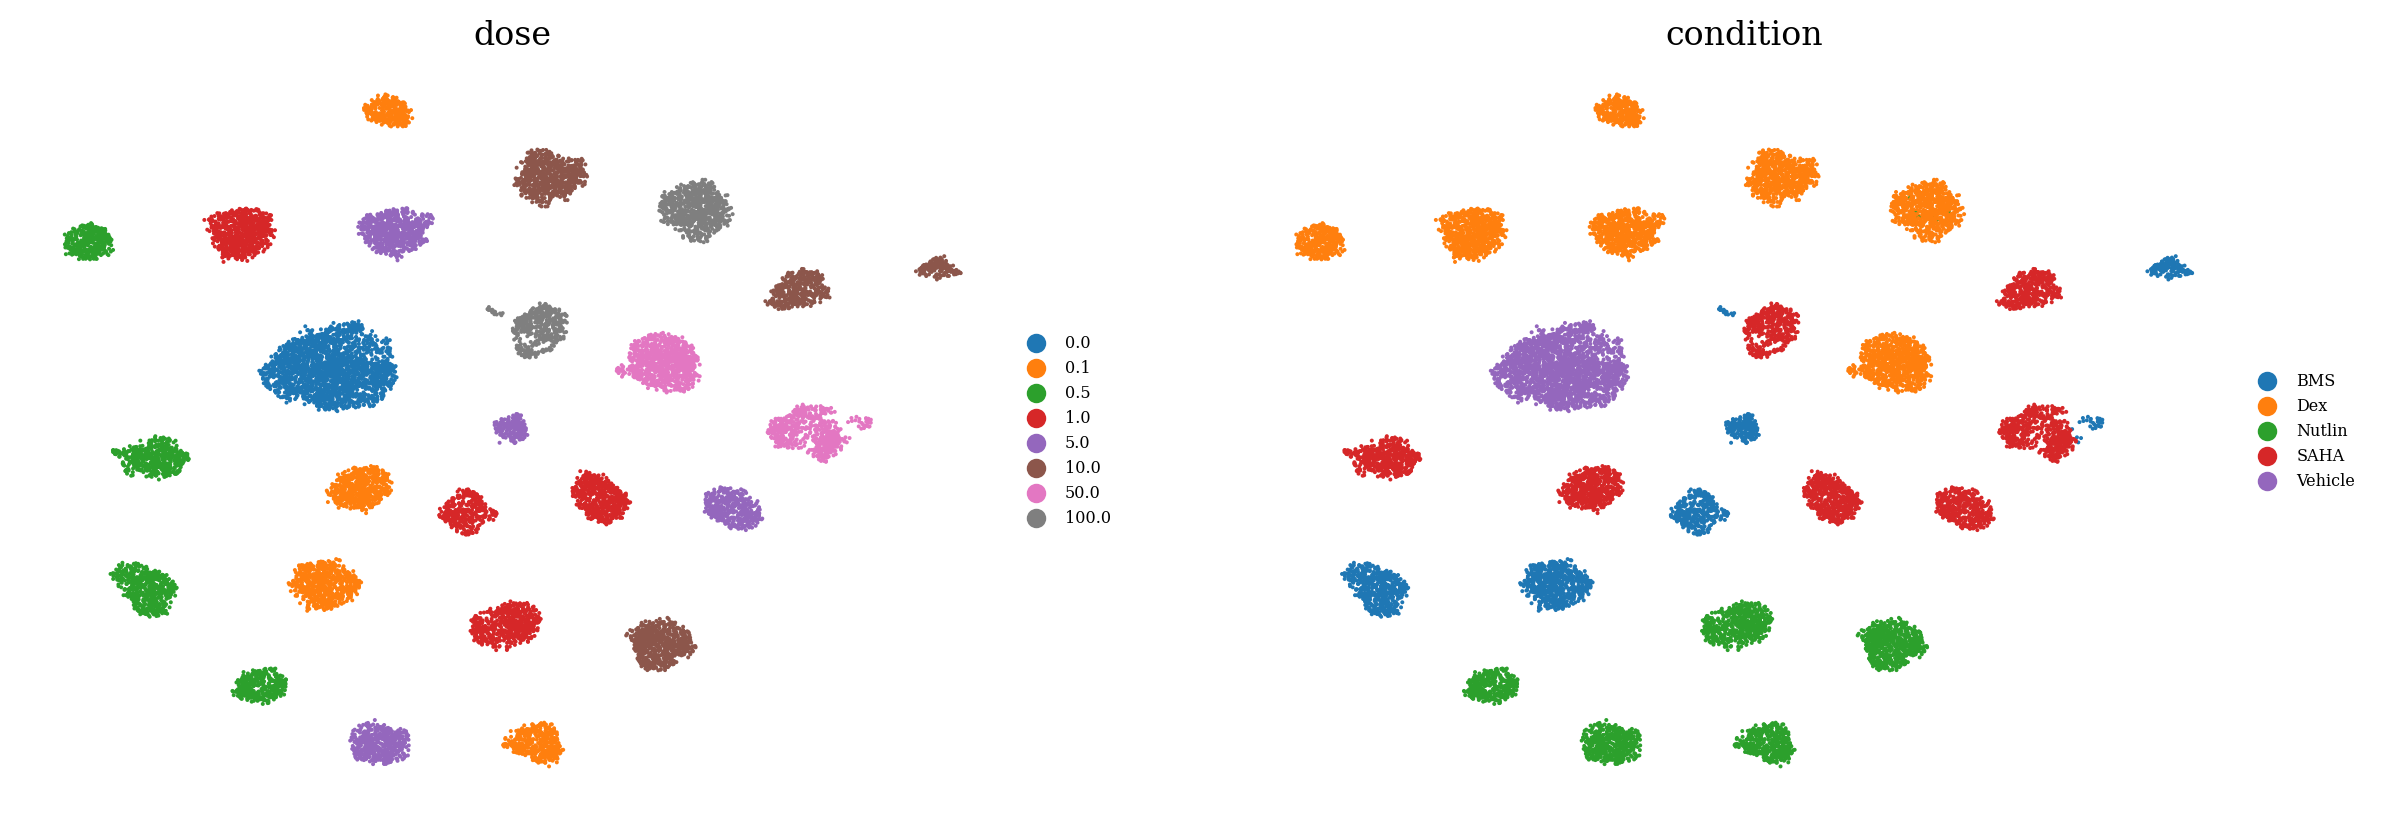

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

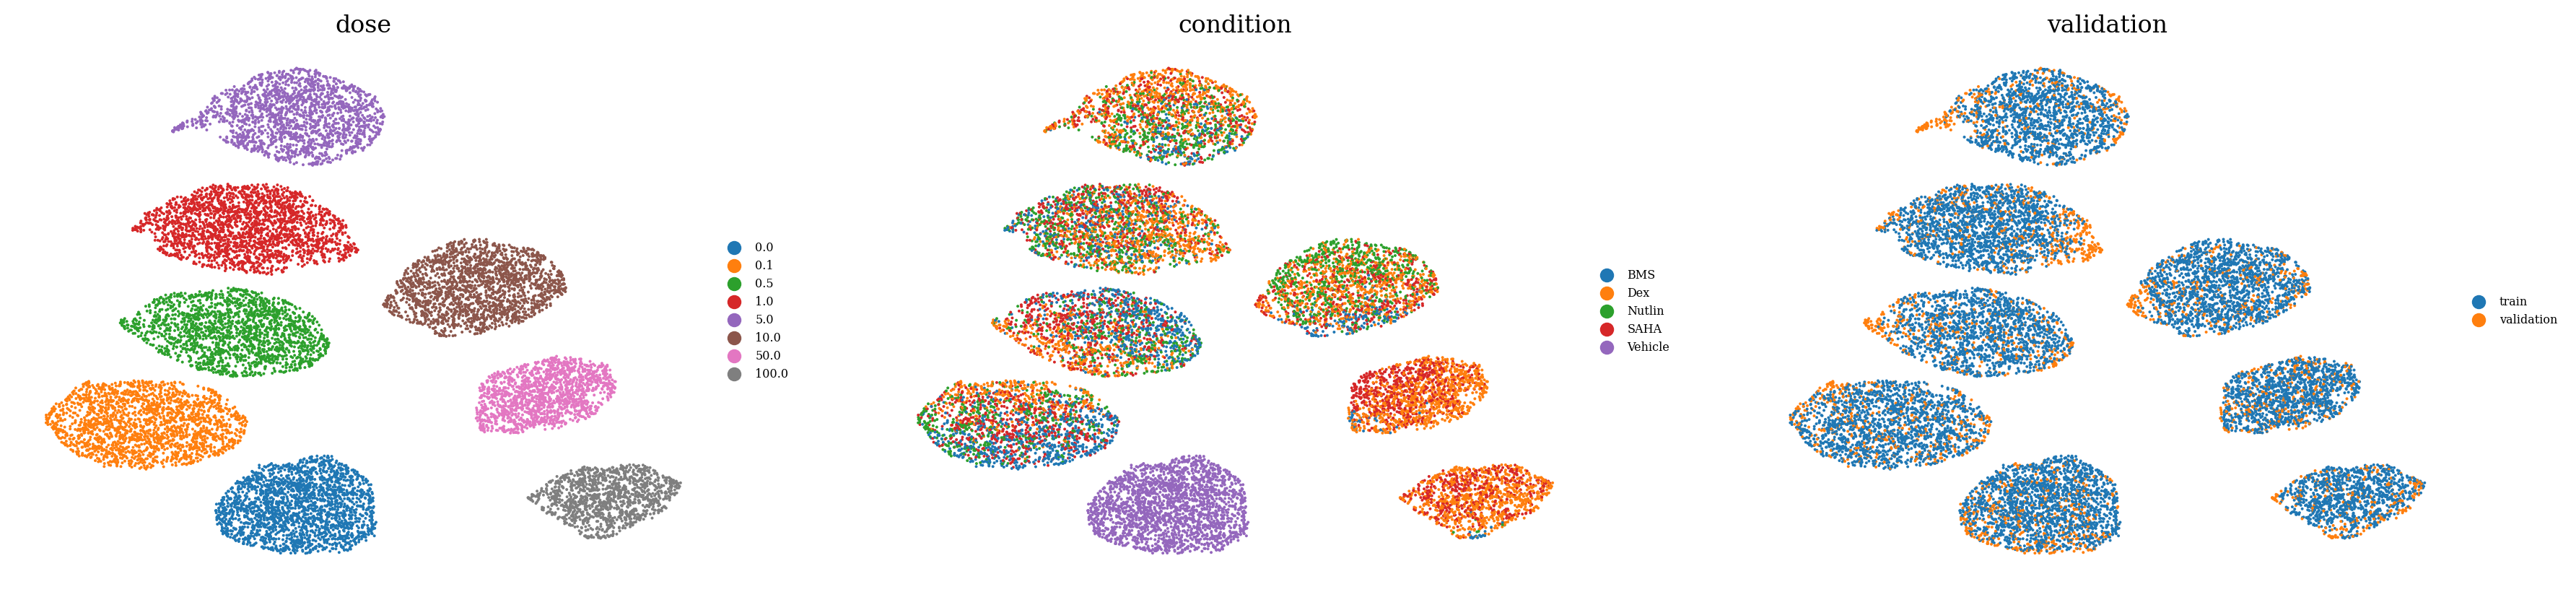

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

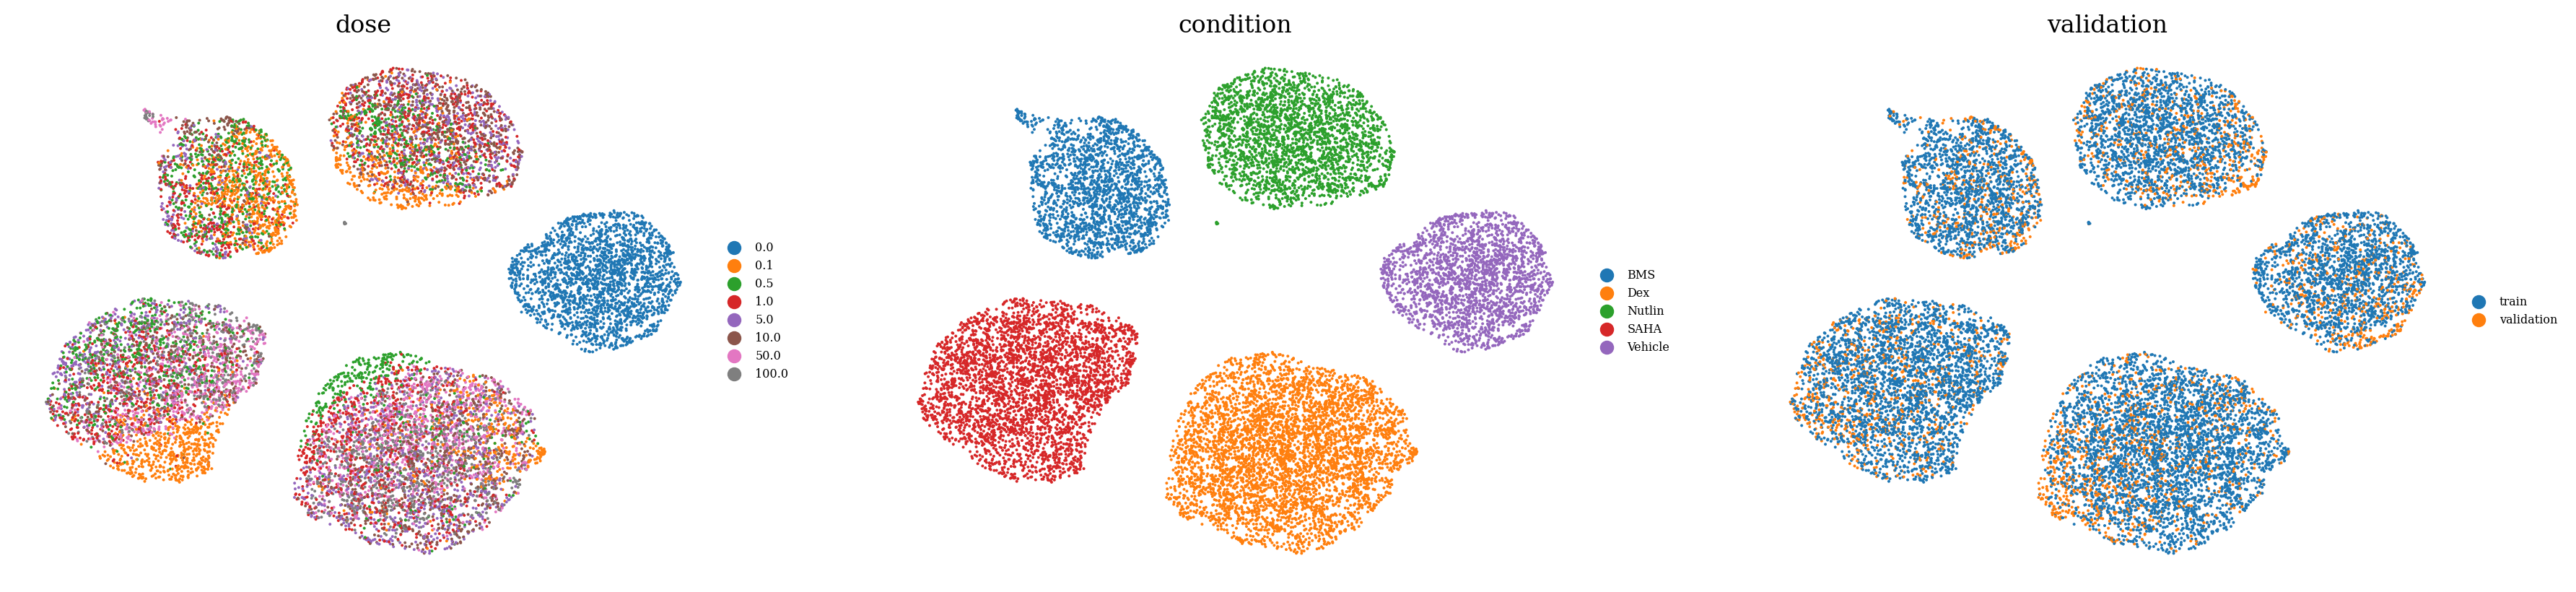

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )